<a href="https://colab.research.google.com/github/VlatekSoft/AI_experiments/blob/main/%D0%92%D0%B5%D0%B1%D0%B8%D0%BD%D0%B0%D1%80_24_%D0%B4%D0%B5%D0%BA%D0%B0%D0%B1%D1%80%D1%8F_24_%D0%9C%D0%B0%D1%80%D0%B0%D1%84%D0%BE%D0%BD_web_%D0%BF%D1%80%D0%B8%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D0%94%D0%B5%D0%BD%D1%8C_3_%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_%D0%B8_%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%87%D0%BD%D1%8B%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **СОЗДАНИЕ ИНТЕРАКТИВНЫХ ИНТЕРФЕЙСОВ: ВРЕМЕННЫЕ РЯДЫ, ТАБЛИЧНЫЕ ДАННЫЕ**

## **1. Приложение финансового анализа (Django+React)**

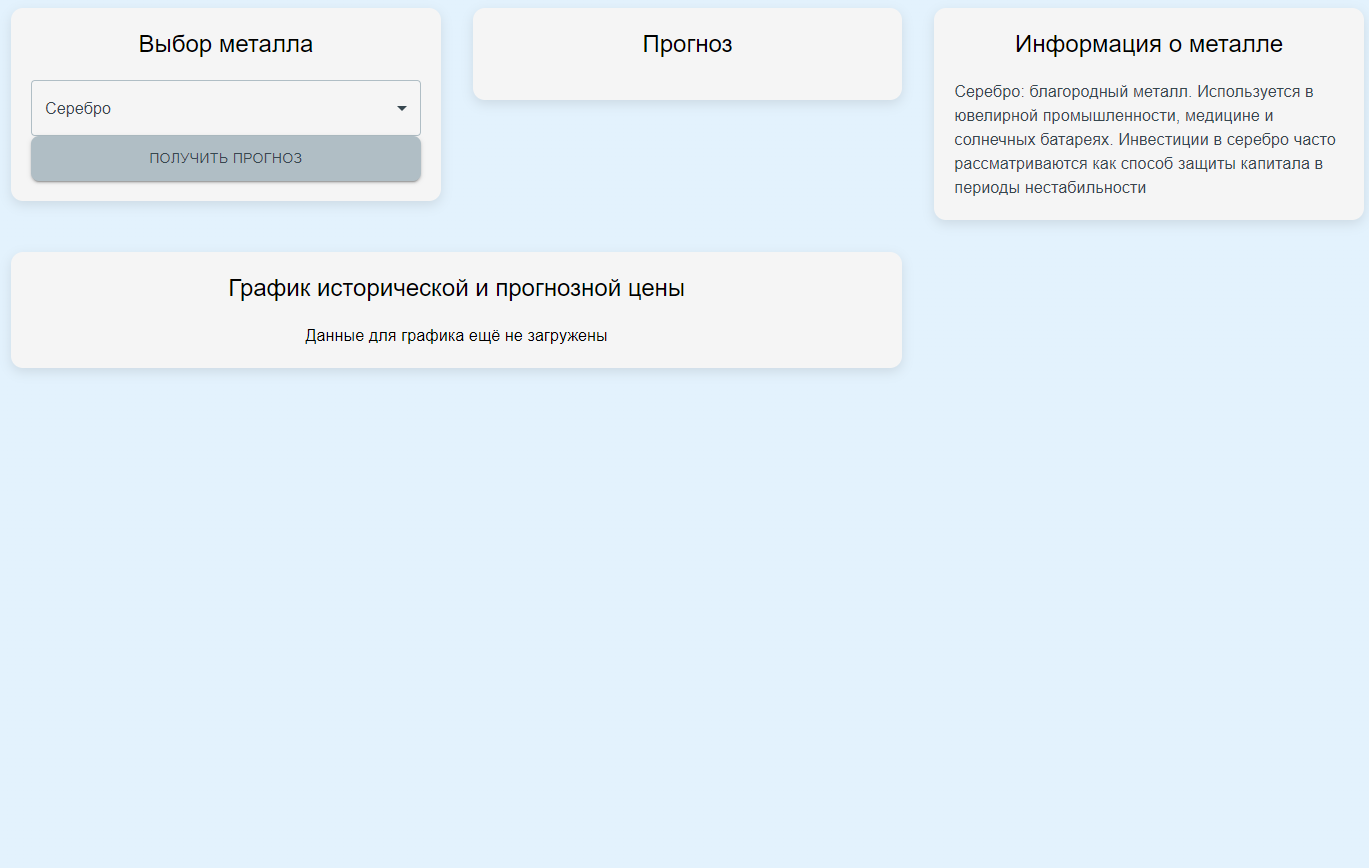

### **Описание структуры проекта**

#### Структура React-сервера

1. **Приложение React (`react-app`)**:
   - `src/App.js`: Основной компонент (выбор металла, API-запросы, отображение результатов анализа).
   - `src/styles.css`: Стили приложения (градиенты, адаптивный дизайн и улучшенный UX).
2. **Функциональность**:
   - Выбор металла для анализа (золото, серебро, медь).
   - API-запросы к Django для получения данных, выполнения анализа и прогнозирования цен.
   - Отображение текущей цены и прогнозируемой цены на графике.
3. **Ngrok**: Проброс локального React-сервера в интернет для тестирования.


#### Структура Django-сервера

1. **Проект Django (`myproject`)**:
   - `settings.py`: Настройки (CORS, базы данных, статические файлы, логирование).
   - `urls.py`: Маршруты проекта (подключение приложения `metalprocessor`).
2. **Приложение (`metalprocessor`)**:
   - `views.py`: Логика обработки данных по металлам (золото, серебро, медь) и  прогнозирования цен.
   - `urls.py`: Локальные маршруты приложения (`/api/metal/` для обработки запросов от React).
3. **Статические файлы и логирование**:
   - `static/`: Хранение файлов, включая графики технического анализа.
   - `django_requests.log`: Логи запросов, результатов анализа и ошибок.
4. **Ngrok**: Проброс локального Django-сервера в интернет для интеграции с React.



#### Связь между серверами

React отправляет запросы на Django (`/api/metal/`), который загрузку данных по выбранному металлу, а также обученную за 10 лет модель и возвращает результаты: текущую цену, прогнозируемую цену и график технического анализа. React отображает полученные данные и визуализацию графика.


### **Запуск проекта**

In [ ]:
# @title ОСТАНОВКА ВСЕХ ПРОЦЕССОВ (ИНИЦИИРОВАТЬ ПЕРЕД КАЖДЫМ ТЕСТИРОВАНИЕМ)
!pkill -f manage.py
!pkill -f ngrok
!pkill -f npm

In [ ]:
# @title Установка Django-сервера и React-сервера
!pip install django
!pip install django-cors-headers
!pip install pandas
!pip install yfinance
!pip install tensorflow
!pip install pyngrok

import os
import re
import json
from django.http import JsonResponse
from django.views.decorators.csrf import csrf_exempt
import pandas as pd
import yfinance as yf
from pyngrok import ngrok
from google.colab import userdata

# Переходим в папку проекта и создаём Django проект
!django-admin startproject myproject
%cd /content/myproject
!python manage.py startapp stockprocessor

# Создаем файл логов заранее
!touch /content/myproject/django_requests.log

# Настроим Ngrok для туннелирования
ngrok_key = userdata.get("NGROK_KEY")
ngrok.set_auth_token(ngrok_key)

# Установка React и Material-UI
!curl -fsSL https://deb.nodesource.com/setup_18.x | bash -
!apt-get install -y nodejs
!npx --yes create-react-app react-app
%cd react-app
!npm install axios
!npm install @mui/material @emotion/react @emotion/styled
!npm install chart.js react-chartjs-2 --legacy-peer-deps
!npm install chartjs-plugin-zoom react-chartjs-2 --legacy-peer-deps

%cd /content/myproject/metalprocessor
!mkdir models

!mkdir -p /content/myproject/static


import gdown
import zipfile

# Путь для сохранения архива и распаковки
zip_url = 'https://drive.google.com/uc?id=1QDjsGAbZf7zEMBY8241jFqdN1fc9Y0fU'
output = '/content/metal_models.zip'
extract_path = '/content/myproject/static/model/'

# 1. Скачиваем ZIP архив
gdown.download(zip_url, output, quiet=False)

# 2. Создаем директорию, если её нет
os.makedirs(extract_path, exist_ok=True)

# 3. Распаковываем архив
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Модели успешно загружены и распакованы в static/model/")


def start_react_server():
    """Функция для запуска React-приложения на порту 3000 с использованием Ngrok."""
    # Остановка запущенных процессов
    os.system("pkill -f manage.py")
    os.system("pkill -f ngrok")

    # Запуск React-приложения в фоновом режиме
    os.system("nohup npm start > react_output.log 2>&1 &")

    try:
        # Настройка Ngrok для проброса порта 3000
        public_url2 = ngrok.connect(3000)
        print(f"React-приложение доступно по адресу:")
        return public_url2
    except Exception as e:
        print(f"Ошибка при подключении Ngrok: {e}")
        return None


def start_django_server():
    """Функция для запуска Django-сервера в фоновом режиме."""
    # Перемещаемся в директорию проекта
    os.chdir("/content/myproject")

    # Применяем миграции базы данных
    os.system("nohup python manage.py migrate > migrate.log 2>&1")

    # Запускаем Django-сервер в фоновом режиме
    os.system("nohup python manage.py runserver 0.0.0.0:8000 > django.log 2>&1 &")

    # Настраиваем Ngrok для проброса порта 8000
    public_url = ngrok.connect(8000)
    print(f"Django-приложение доступно по адресу: {public_url}")

    return public_url


# Обновление файл settings.py с новыми настройками
# Путь к файлу settings.py
file_path = "/content/myproject/myproject/settings.py"

# Читаем содержимое файла settings.py
with open(file_path, "r") as file:
    content = file.read()

# Извлекаем значение SECRET_KEY
secret_key_match = re.search(r'SECRET_KEY\s*=\s*[\'"](.+?)[\'"]', content)
if secret_key_match:
    secret_key = secret_key_match.group(1)
else:
    raise ValueError("SECRET_KEY не найден в файле.")

# Новое содержимое settings.py
text_s = f"""
SECRET_KEY = '{secret_key}'

from pathlib import Path
import os

BASE_DIR = Path(__file__).resolve().parent.parent

DEBUG = True

ALLOWED_HOSTS = ['*']  # Разрешить запросы с любых хостов

INSTALLED_APPS = [
    'corsheaders',  # Добавить приложение для обработки CORS
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    'metalprocessor',  # Приложение для обработки изображений
]

MIDDLEWARE = [
    'corsheaders.middleware.CorsMiddleware',  # CORS обработчик
    'django.middleware.common.CommonMiddleware',
    'django.middleware.security.SecurityMiddleware',
    'django.contrib.sessions.middleware.SessionMiddleware',
    'django.middleware.csrf.CsrfViewMiddleware',
    'django.contrib.auth.middleware.AuthenticationMiddleware',
    'django.contrib.messages.middleware.MessageMiddleware',
    'django.middleware.clickjacking.XFrameOptionsMiddleware',
]

DATA_UPLOAD_MAX_MEMORY_SIZE = 10485760  # 10MB

CORS_ALLOW_ALL_ORIGINS = True  # Разрешить запросы с любых доменов
CORS_ALLOW_METHODS = ['GET', 'POST', 'OPTIONS']  # Разрешенные HTTP методы
CORS_ALLOW_HEADERS = ['content-type', 'authorization']  # Разрешенные заголовки

ROOT_URLCONF = 'myproject.urls'

TEMPLATES = [
    {{
        'BACKEND': 'django.template.backends.django.DjangoTemplates',
        'DIRS': [BASE_DIR / 'templates'],  # Папка для шаблонов, если нужна
        'APP_DIRS': True,
        'OPTIONS': {{
            'context_processors': [
                'django.template.context_processors.debug',
                'django.template.context_processors.request',  # Это важно для админки
                'django.contrib.auth.context_processors.auth',
                'django.contrib.messages.context_processors.messages',
            ],
        }},
    }},
]

WSGI_APPLICATION = 'myproject.wsgi.application'

DATABASES = {{
    'default': {{
        'ENGINE': 'django.db.backends.sqlite3',
        'NAME': BASE_DIR / 'db.sqlite3',
    }}
}}

AUTH_PASSWORD_VALIDATORS = [
    {{
        'NAME': 'django.contrib.auth.password_validation.UserAttributeSimilarityValidator',
    }},
    {{
        'NAME': 'django.contrib.auth.password_validation.MinimumLengthValidator',
    }},
    {{
        'NAME': 'django.contrib.auth.password_validation.CommonPasswordValidator',
    }},
    {{
        'NAME': 'django.contrib.auth.password_validation.NumericPasswordValidator',
    }},
]

LANGUAGE_CODE = 'en-us'

TIME_ZONE = 'UTC'

USE_I18N = True

USE_TZ = True

LOGGING = {{
    'version': 1,
    'disable_existing_loggers': True,  # Полностью отключить все стандартные логеры Django
    'formatters': {{
        'verbose': {{
            'format': '{{levelname}} {{asctime}} {{module}} {{message}}',
            'style': '{{',
        }},
    }},
    'handlers': {{
        'file': {{
            'level': 'INFO',  # Логируются только сообщения уровня INFO и выше
            'class': 'logging.FileHandler',
            'filename': os.path.join(BASE_DIR, 'django_requests.log'),
            'formatter': 'verbose',
        }},
    }},
    'loggers': {{
        'views': {{  # Логирование только из views.py
            'handlers': ['file'],
            'level': 'INFO',  # Логируются только сообщения уровня INFO и выше
            'propagate': False,  # Не передавать логи другим логгерам
        }},
    }},
}}

STATIC_URL = '/static/'
MEDIA_URL = '/media/'
MEDIA_ROOT = BASE_DIR / 'static/uploads'

# Если вы используете статику в разработке, укажите путь к папке
STATICFILES_DIRS = [
    BASE_DIR / "static",  # Папка с вашими статическими файлами
]

# Для продакшн-окружения
STATIC_ROOT = BASE_DIR / 'staticfiles'

DEFAULT_AUTO_FIELD = 'django.db.models.BigAutoField'
"""

# Перезаписываем файл settings.py с новыми настройками
with open(file_path, "w") as file:
    file.write(text_s)

# @title Обновление маршрутов для Django

# Переход в директорию проекта
%cd /content/myproject

# Создание папки для приложения metalprocessor, если её нет
os.makedirs('/content/myproject/metalprocessor', exist_ok=True)

# Создание файла urls.py в приложении metalprocessor
metalprocessor_urls_path = "/content/myproject/metalprocessor/urls.py"
with open(metalprocessor_urls_path, 'w') as f:
    f.write("""
from django.urls import path
from .views import process_metal  # Импорт обработчика из views

urlpatterns = [
    path('metal/', process_metal, name='process_metal'),  # Маршрут для обработки изображений
]
""")
print("Файл urls.py для приложения metalprocessor создан или обновлён.")

# Обновление основного файла urls.py проекта
project_urls_path = "/content/myproject/myproject/urls.py"
urls_content = """
from django.contrib import admin
from django.urls import path, include

urlpatterns = [
    path('api/', include('metalprocessor.urls')),  # Подключаем маршруты из metalprocessor
    path('admin/', admin.site.urls),
]
"""

with open(project_urls_path, "w") as file:
    file.write(urls_content)

print("Файл urls.py для проекта обновлён.")

# Создание файла views.py в приложении metalprocessor, если его нет
metalprocessor_views_path = "/content/myproject/metalprocessor/views.py"
if not os.path.exists(metalprocessor_views_path):
    with open(metalprocessor_views_path, 'w') as f:
        f.write("""
from django.http import JsonResponse

def process_metal(request):
    return JsonResponse({"message": "Обработчик пока не настроен"})
""")
    print("Файл views.py для приложения metalprocessor создан.")
else:
    print("Файл views.py для приложения metalprocessor уже существует.")


# Переходим в папку сервера react
%cd /content/myproject/react-app

# Создаем динамическую ссылку
link_r = ""

text_ob_react = f"""
import React, {{ useState }} from "react";
import "./styles.css"; // Подключаем файл стилей
import {{ Grid, Box, Button, Typography, Select, MenuItem }} from "@mui/material";
import {{ Line }} from "react-chartjs-2"; // Импортируем Line для графика
import {{ Chart, registerables }} from 'chart.js';
import zoomPlugin from 'chartjs-plugin-zoom';

// Регистрируем все компоненты Chart.js
Chart.register(...registerables);
Chart.register(zoomPlugin);

function App() {{
  const [selectedMetal, setSelectedMetal] = useState(""); // Для хранения выбранного металла
  const [isProcessing, setIsProcessing] = useState(false); // Флаг обработки
  const [currentPrice, setCurrentPrice] = useState(null); // Для хранения текущей цены
  const [result, setResult] = useState([]);  // по умолчанию пустой массив
  const [chartData, setChartData] = useState(null);  // Сначала null, пока не загрузится

  const metalInfo = {{
    silver: "Серебро: благородный металл. Используется в ювелирной промышленности, медицине и солнечных батареях. Инвестиции в серебро часто рассматриваются как способ защиты капитала в периоды нестабильности",
    gold: "Золото: символ богатства. Применяется в ювелирной промышленности, резервах и космических технологиях. Золото считается одним из самых надёжных активов для инвесторов, особенно в периоды инфляции и нестабильности.",
    copper: "Медь: основа электроники. Используется в кабелях, строительстве и аккумуляторах. В мире инвестиций медь считается индикатором экономического роста, так как её цена тесно связана с уровнем промышленного производства",
  }};

  const handleMetalChange = (event) => {{
    setSelectedMetal(event.target.value);
    setCurrentPrice(null);
    setResult([]);
    setChartData(null);
  }};

  const handleSubmit = async (e) => {{
    e.preventDefault();

    if (!selectedMetal) {{
      alert("Пожалуйста, выберите металл");
      return;
    }}

    const formData = new FormData();
    formData.append("metal", selectedMetal);

    setIsProcessing(true);

    try {{
      const response = await fetch(`{link_r}/api/metal/`, {{
        method: "POST",
        body: formData,
      }});

      if (!response.ok) {{
        throw new Error("Ошибка сервера");
      }}

      const data = await response.json();

      // Сохраняем текущую цену и прогнозируемую цену
      setCurrentPrice(data.current_price);
      setResult(data.predicted_price);

      // Устанавливаем данные для графика
      setChartData({{
        labels: data.chart_data.labels,
        datasets: data.chart_data.datasets,
      }});

    }} catch (error) {{
      alert("Произошла ошибка: " + error.message);
    }} finally {{
      setIsProcessing(false);
    }}
  }};

  return (
    <Box
      sx={{{{
        background: "linear-gradient(180deg, #E3F2FD, #E3F2FD)",
        height: "100vh",
        padding: "20px",
      }}}}
    >
      <Grid container spacing={{4}}>
        {{/* Левая панель */}}
        <Grid item xs={{12}} md={{4}}>
          <Box
            sx={{{{
              background: "#F5F5F5",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)",
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Выбор металла
            </Typography>
            <Select
              value={{selectedMetal}}
              onChange={{handleMetalChange}}
              fullWidth
              variant="outlined"
              sx={{{{
                backgroundColor: "#F5F5F5", // Светло-серый фон
                color: "#37474F", // Тёмно-серый текст
                '& .MuiOutlinedInput-notchedOutline': {{
                borderColor: "#B0BEC5", // Цвет границы
                }},
                '&:hover .MuiOutlinedInput-notchedOutline': {{
                borderColor: "#90A4AE", // Светло-серый при наведении
                }},
                '&.Mui-focused .MuiOutlinedInput-notchedOutline': {{
                borderColor: "#6B7280", // Средне-серый при фокусе
                }},
                '& .MuiSelect-icon': {{
                color: "#37474F", // Тёмно-серая стрелка
                }},
              }}}}
            >
              <MenuItem value="">Выберите металл</MenuItem>
              <MenuItem value="silver">Серебро</MenuItem>
              <MenuItem value="gold">Золото</MenuItem>
              <MenuItem value="copper">Медь</MenuItem>
            </Select>
            <Button
              onClick={{handleSubmit}}
              disabled={{isProcessing}}
              variant="contained"
              color="default"
              sx={{{{
                  backgroundColor: "#B0BEC5", // Средний серый
                  color: "#37474F", // Тёмный серый текст
                  '&:hover': {{
                  backgroundColor: "#90A4AE", // Светлее при наведении
                  }},
                  borderRadius: "8px", // Более мягкие углы
                  padding: "10px 20px",
              }}}}
              fullWidth
            >
              {{isProcessing ? "Обрабатываем..." : "Получить прогноз"}}
            </Button>
          </Box>
        </Grid>

        {{/* Центральная панель */}}
        <Grid item xs={{12}} md={{4}}>
          <Box
            sx={{{{
              background: "#F5F5F5",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)",
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Прогноз
            </Typography>
            {{currentPrice && (
              <Typography variant="h6">
                <strong>Текущая цена:</strong> {{currentPrice.toFixed(2)}} $
              </Typography>
            )}}
            {{result && result.length > 0 && (
              <Box sx={{{{ marginTop: "20px" }}}}>
                <Typography variant="h6">
                  <strong>Прогноз на 5 дней:</strong>
                </Typography>
                <ul>
                  {{result.map((price, index) => (
                    <li key={{index}}>
                      День {{index + 1}}: {{price.toFixed(2)}} $
                    </li>
                  ))}}
                </ul>
              </Box>
            )}}
          </Box>
        </Grid>

        {{/* Правая панель */}}
        <Grid item xs={{12}} md={{4}} sx={{{{ height: "100%" }}}}>
          <Box
            sx={{{{
              background: "#F5F5F5",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)",
              height: "100%", // Панель на всю высоту
              display: "flex",
              flexDirection: "column", // Позволяет разместить содержимое вертикально
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Информация о металле
            </Typography>
            {{selectedMetal ? (
              <Typography variant="body1" sx={{{{ color: "#37474F" }}}}>
                {{metalInfo[selectedMetal]}}
              </Typography>
            ) : (
              <Typography variant="body1" sx={{{{ color: "#6B7280", textAlign: "center" }}}}>
                Выберите металл, чтобы увидеть информацию.
              </Typography>
            )}}
          </Box>
        </Grid>

        {{/* Нижняя панель */}}
        <Grid item xs={{12}} md={{8}}>
          <Box
            sx={{{{
              background: "#F5F5F5",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)",
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              График исторической и прогнозной цены
            </Typography>
            {{chartData ? (
              <Line
                data={{chartData}}
                options={{{{
                  responsive: true,
                  plugins: {{
                    legend: {{
                      position: 'top',
                    }},
                    zoom: {{
                      pan: {{
                        enabled: true,
                        mode: "x",
                      }},
                      zoom: {{
                        wheel: {{
                          enabled: true,
                        }},
                        pinch: {{
                          enabled: true
                        }},
                        mode: "x",
                      }}
                    }}
                  }},
                  scales: {{
                    y: {{
                      beginAtZero: false,
                      title: {{
                        display: true,
                        text: 'Цена закрытия',
                      }},
                      ticks: {{
                        callback: function (value) {{
                          return value.toFixed(2) + ' $';
                        }}
                      }},
                      // Динамический диапазон от min до max значений
                      min: chartData ? Math.min(...chartData.datasets[0].data.flat()) * 0.95 : undefined,
                      max: chartData ? Math.max(...chartData.datasets[0].data.flat()) * 1.05 : undefined,
                    }},
                    x: {{
                      title: {{
                        display: true,
                        text: 'Дата',
                      }},
                    }}
                  }},
                }}}}
              />
            ) : (
              <Typography variant="body1" sx={{{{ textAlign: "center", marginTop: "20px" }}}}>
                  Данные для графика ещё не загружены
              </Typography>
            )}}
          </Box>
        </Grid>
      </Grid>
    </Box>
  );
}}

export default App;
"""

# Сохраняем файл App.js
with open("src/App.js", "w") as file:
    file.write(text_ob_react)


text_ob_styles = """
body {
  margin: 0;
  font-family: "Roboto", sans-serif;
  background: linear-gradient(180deg, #e3f2fd, #bbdefb);
  min-height: 100vh;
}
"""
# Сохраняем файл styles.css
with open("src/styles.css", "w") as file:
    file.write(text_ob_styles)


text_ob_django = """
import os
import json
import logging
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from django.http import JsonResponse
from django.views.decorators.csrf import csrf_exempt
import base64
from io import BytesIO
from sklearn.linear_model import LinearRegression  # (Линейную регрессию пока оставляем)
import tensorflow as tf
from tensorflow.keras.models import load_model  # Для загрузки LSTM модели
import joblib  # Для загрузки scaler'ов
from tensorflow.keras.losses import MeanSquaredError

# Настраиваем логирование
logger = logging.getLogger('views')


# Функция для получения данных о металле из yfinance
def get_metal_data(metal):  # Функция для получения данных о ценах на металл
    try:
        tickers = {'silver': 'SI=F', 'gold': 'GC=F', 'copper': 'HG=F'}
        ticker = tickers[metal]  # Получаем тикер для металла

        # Загружаем данные за последние 6 месяцев с дневным интервалом
        data = yf.download(ticker, period="6mo", interval="1d")

        if data.empty or len(data) < 30:
            logger.error(f"Недостаточно данных для металла {metal}. Нужно минимум 30 записей.")
            raise ValueError("Недостаточно данных для прогноза.")

        logger.info(f"Данные за последние 30 дней для {metal} успешно загружены.")
        return data
    except Exception as e:
        logger.error(f"Ошибка при получении данных для металла {metal}: {str(e)}")
        raise

# Функция для выполнения расширенного технического анализа и возврата данных в JSON
def perform_technical_analysis(data):
    try:
        # Подготовка JSON с чистыми данными по цене закрытия
        chart_data = {
            "labels": data.index.strftime('%Y-%m-%d').tolist(),
            "datasets": [
                {
                    "label": "Цена закрытия",
                    "data": [price[0] if isinstance(price, list) else price for price in data['Close'].values.tolist()],
                    "borderColor": "blue",
                    "fill": False,
                }
            ]
        }

        logger.info("Данные для графика (только Цена закрытия) успешно подготовлены.")
        return chart_data

    except Exception as e:
        logger.error(f"Ошибка при выполнении технического анализа: {str(e)}")
        raise

# Функция для прогнозирования цены через 5 дней
def predict_price(data, metal):
    try:
        # Путь к модели и scaler'у
        model_path = f'/content/myproject/static/model/content/metal_models/{metal}_lstm_model.h5'
        scaler_path = f'/content/myproject/static/model/content/metal_models/{metal}_scaler.pkl'

        # Проверяем существование модели
        if not os.path.exists(model_path) or not os.path.exists(scaler_path):
            logger.error(f"Модель или scaler для {metal} не найдены.")
            raise ValueError(f"Модель для {metal} не найдена!")

        # Загружаем модель и scaler
        model = load_model(model_path, custom_objects={'mse': MeanSquaredError()})
        scaler = joblib.load(scaler_path)
        logger.info(f"Модель LSTM для {metal} успешно загружена.")

        # Масштабируем данные
        scaled_data = scaler.transform(data[['Close']].values)

        # Подготовка входных данных: последние 30 дней
        sequence_length = 30
        last_30_days = scaled_data[-sequence_length:]
        X_input = np.reshape(last_30_days, (1, sequence_length, 1))

        # Прогноз на 5 дней вперед
        predictions = []
        for _ in range(5):
            pred = model.predict(X_input)
            predictions.append(pred[0][0])

            # Сдвигаем окно предсказания
            X_input = np.append(X_input[:, 1:, :], [[[pred[0][0]]]], axis=1)

        # Обратное преобразование масштабов
        predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

        # Логируем и возвращаем прогноз на 5 дней вперед
        logger.info(f"Прогноз на 5 дней для {metal}: {predicted_prices.flatten()}")
        return predicted_prices.flatten().tolist()

    except Exception as e:
        logger.error(f"Ошибка при прогнозировании цены: {str(e)}")
        raise

@csrf_exempt
def process_metal(request):
    if request.method == 'POST':
        try:
            selected_metal = request.POST.get("metal")
            if not selected_metal:
                logger.warning("Металл не был выбран в запросе.")
                return JsonResponse({"error": "Металл не выбран!"}, status=400)

            metal_data = get_metal_data(selected_metal)
            current_price = float(metal_data['Close'].iloc[-1])

            # Прогнозируем 5 дней
            predicted_prices = predict_price(metal_data, selected_metal)

            # Добавляем прогнозируемые цены к данным для графика
            chart_data = perform_technical_analysis(metal_data)

            # Расширяем данные и метки на графике
            last_date = metal_data.index[-1]
            future_dates = pd.date_range(start=last_date, periods=7, inclusive='right')

            # Добавляем прогнозируемые даты к labels
            chart_data['labels'].extend(future_dates.strftime('%Y-%m-%d').tolist())

            # Добавляем прогнозируемые цены в конец графика
            forecast_data = [None] * len(chart_data['datasets'][0]['data']) + predicted_prices

            # Добавляем их как новый dataset с красной линией
            chart_data['datasets'].append({
                "label": "Прогноз (на 5 дней)",
                "data": forecast_data,
                "borderColor": "red",
                "fill": False,
                "pointRadius": 5,
                "pointBackgroundColor": "red"
            })

            response_data = {
                "current_price": current_price,
                "predicted_price": predicted_prices,
                "chart_data": chart_data
            }

            logger.info(f"Успешно сформирован ответ для металла {selected_metal}.")
            return JsonResponse(response_data)
        except Exception as e:
            logger.error(f"Ошибка обработки запроса: {str(e)}")
            return JsonResponse({"error": str(e)}, status=500)
    return JsonResponse({"error": "Некорректный метод запроса"}, status=400)
"""

# Записываем код в файл Django view
views_file_path = '/content/myproject/metalprocessor/views.py'
with open(views_file_path, 'w') as views_file:
    views_file.write(text_ob_django)



def update_react_component_with_new_url(public_url):
    # Переходим в папку сервера react
    %cd /content/myproject/react-app

    # Извлечение URL с использованием регулярного выражения
    public_url_str = str(public_url)
    match = re.search(r'https://[^\s"]+', public_url_str)

    if match:
        link_r = match.group(0)
    else:
        print("URL не найден.")
        return

    # Создаем новый React-компонент с актуальным адресом
    text_ob_react = f"""
import React, {{ useState }} from "react";
import "./styles.css"; // Подключаем файл стилей
import {{ Grid, Box, Button, Typography, Select, MenuItem }} from "@mui/material";
import {{ Line }} from "react-chartjs-2"; // Импортируем Line для графика
import {{ Chart, registerables }} from 'chart.js';
import zoomPlugin from 'chartjs-plugin-zoom';

// Регистрируем все компоненты Chart.js
Chart.register(...registerables);
Chart.register(zoomPlugin);

function App() {{
  const [selectedMetal, setSelectedMetal] = useState(""); // Для хранения выбранного металла
  const [isProcessing, setIsProcessing] = useState(false); // Флаг обработки
  const [currentPrice, setCurrentPrice] = useState(null); // Для хранения текущей цены
  const [result, setResult] = useState([]);  // по умолчанию пустой массив
  const [chartData, setChartData] = useState(null);  // Сначала null, пока не загрузится

  const metalInfo = {{
    silver: "Серебро: благородный металл. Используется в ювелирной промышленности, медицине и солнечных батареях. Инвестиции в серебро часто рассматриваются как способ защиты капитала в периоды нестабильности",
    gold: "Золото: символ богатства. Применяется в ювелирной промышленности, резервах и космических технологиях. Золото считается одним из самых надёжных активов для инвесторов, особенно в периоды инфляции и нестабильности.",
    copper: "Медь: основа электроники. Используется в кабелях, строительстве и аккумуляторах. В мире инвестиций медь считается индикатором экономического роста, так как её цена тесно связана с уровнем промышленного производства",
  }};

  const handleMetalChange = (event) => {{
    setSelectedMetal(event.target.value);
    setCurrentPrice(null);
    setResult([]);
    setChartData(null);
  }};

  const handleSubmit = async (e) => {{
    e.preventDefault();

    if (!selectedMetal) {{
      alert("Пожалуйста, выберите металл");
      return;
    }}

    const formData = new FormData();
    formData.append("metal", selectedMetal);

    setIsProcessing(true);

    try {{
      const response = await fetch(`{link_r}/api/metal/`, {{
        method: "POST",
        body: formData,
      }});

      if (!response.ok) {{
        throw new Error("Ошибка сервера");
      }}

      const data = await response.json();

      // Сохраняем текущую цену и прогнозируемую цену
      setCurrentPrice(data.current_price);
      setResult(data.predicted_price);

      // Устанавливаем данные для графика
      setChartData({{
        labels: data.chart_data.labels,
        datasets: data.chart_data.datasets,
      }});

    }} catch (error) {{
      alert("Произошла ошибка: " + error.message);
    }} finally {{
      setIsProcessing(false);
    }}
  }};

  return (
    <Box
      sx={{{{
        background: "linear-gradient(180deg, #E3F2FD, #E3F2FD)",
        height: "100vh",
        padding: "20px",
      }}}}
    >
      <Grid container spacing={{4}}>
        {{/* Левая панель */}}
        <Grid item xs={{12}} md={{4}}>
          <Box
            sx={{{{
              background: "#F5F5F5",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)",
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Выбор металла
            </Typography>
            <Select
              value={{selectedMetal}}
              onChange={{handleMetalChange}}
              fullWidth
              variant="outlined"
              sx={{{{
                backgroundColor: "#F5F5F5", // Светло-серый фон
                color: "#37474F", // Тёмно-серый текст
                '& .MuiOutlinedInput-notchedOutline': {{
                borderColor: "#B0BEC5", // Цвет границы
                }},
                '&:hover .MuiOutlinedInput-notchedOutline': {{
                borderColor: "#90A4AE", // Светло-серый при наведении
                }},
                '&.Mui-focused .MuiOutlinedInput-notchedOutline': {{
                borderColor: "#6B7280", // Средне-серый при фокусе
                }},
                '& .MuiSelect-icon': {{
                color: "#37474F", // Тёмно-серая стрелка
                }},
              }}}}
            >
              <MenuItem value="">Выберите металл</MenuItem>
              <MenuItem value="silver">Серебро</MenuItem>
              <MenuItem value="gold">Золото</MenuItem>
              <MenuItem value="copper">Медь</MenuItem>
            </Select>
            <Button
              onClick={{handleSubmit}}
              disabled={{isProcessing}}
              variant="contained"
              color="default"
              sx={{{{
                  backgroundColor: "#B0BEC5", // Средний серый
                  color: "#37474F", // Тёмный серый текст
                  '&:hover': {{
                  backgroundColor: "#90A4AE", // Светлее при наведении
                  }},
                  borderRadius: "8px", // Более мягкие углы
                  padding: "10px 20px",
              }}}}
              fullWidth
            >
              {{isProcessing ? "Обрабатываем..." : "Получить прогноз"}}
            </Button>
          </Box>
        </Grid>

        {{/* Центральная панель */}}
        <Grid item xs={{12}} md={{4}}>
          <Box
            sx={{{{
              background: "#F5F5F5",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)",
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Прогноз
            </Typography>
            {{currentPrice && (
              <Typography variant="h6">
                <strong>Текущая цена:</strong> {{currentPrice.toFixed(2)}} $
              </Typography>
            )}}
            {{result && result.length > 0 && (
              <Box sx={{{{ marginTop: "20px" }}}}>
                <Typography variant="h6">
                  <strong>Прогноз на 5 дней:</strong>
                </Typography>
                <ul>
                  {{result.map((price, index) => (
                    <li key={{index}}>
                      День {{index + 1}}: {{price.toFixed(2)}} $
                    </li>
                  ))}}
                </ul>
              </Box>
            )}}
          </Box>
        </Grid>

        {{/* Правая панель */}}
        <Grid item xs={{12}} md={{4}} sx={{{{ height: "100%" }}}}>
          <Box
            sx={{{{
              background: "#F5F5F5",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)",
              height: "100%", // Панель на всю высоту
              display: "flex",
              flexDirection: "column", // Позволяет разместить содержимое вертикально
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Информация о металле
            </Typography>
            {{selectedMetal ? (
              <Typography variant="body1" sx={{{{ color: "#37474F" }}}}>
                {{metalInfo[selectedMetal]}}
              </Typography>
            ) : (
              <Typography variant="body1" sx={{{{ color: "#6B7280", textAlign: "center" }}}}>
                Выберите металл, чтобы увидеть информацию.
              </Typography>
            )}}
          </Box>
        </Grid>

        {{/* Нижняя панель */}}
        <Grid item xs={{12}} md={{8}}>
          <Box
            sx={{{{
              background: "#F5F5F5",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)",
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              График исторической и прогнозной цены
            </Typography>
            {{chartData ? (
              <Line
                data={{chartData}}
                options={{{{
                  responsive: true,
                  plugins: {{
                    legend: {{
                      position: 'top',
                    }},
                    zoom: {{
                      pan: {{
                        enabled: true,
                        mode: "x",
                      }},
                      zoom: {{
                        wheel: {{
                          enabled: true,
                        }},
                        pinch: {{
                          enabled: true
                        }},
                        mode: "x",
                      }}
                    }}
                  }},
                  scales: {{
                    y: {{
                      beginAtZero: false,
                      title: {{
                        display: true,
                        text: 'Цена закрытия',
                      }},
                      ticks: {{
                        callback: function (value) {{
                          return value.toFixed(2) + ' $';
                        }}
                      }},
                      // Динамический диапазон от min до max значений
                      min: chartData ? Math.min(...chartData.datasets[0].data.flat()) * 0.95 : undefined,
                      max: chartData ? Math.max(...chartData.datasets[0].data.flat()) * 1.05 : undefined,
                    }},
                    x: {{
                      title: {{
                        display: true,
                        text: 'Дата',
                      }},
                    }}
                  }},
                }}}}
              />
            ) : (
              <Typography variant="body1" sx={{{{ textAlign: "center", marginTop: "20px" }}}}>
                  Данные для графика ещё не загружены
              </Typography>
            )}}
          </Box>
        </Grid>
      </Grid>
    </Box>
  );
}}

export default App;
"""

    # Сохраняем обновленный файл App.js
    with open("src/App.js", "w") as file:
        file.write(text_ob_react)
    print("React компонент успешно обновлен с новым адресом.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.3 MB/s eta 0:00:00
/content/myproject
2024-12-24 16:18:52 - Installing pre-requisites
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,614 kB]
Get:12 

Downloading...
From: https://drive.google.com/uc?id=1QDjsGAbZf7zEMBY8241jFqdN1fc9Y0fU
To: /content/metal_models.zip
100%|██████████| 2.47M/2.47M [00:00<00:00, 79.3MB/s]

Модели успешно загружены и распакованы в static/model/
/content/myproject
Файл urls.py для приложения metalprocessor создан или обновлён.
Файл urls.py для проекта обновлён.
Файл views.py для приложения metalprocessor создан.
/content/myproject/react-app


#### **Создание фронтенда (файл App.js)**

[Ссылка на интерфейс проекта в песочнице sandbox](https://codesandbox.io/p/sandbox/9htm2f)

#### **Функция для запуска React-приложения в фоновом режиме на порту 3000 с использованием Ngrok.**

In [ ]:
start_react_server()

React-приложение доступно по адресу:


<NgrokTunnel: "https://f6f5-34-86-60-208.ngrok-free.app" -> "http://localhost:3000">

#### **Создание бэкэнда Django (файл views.py) ЗАПУСК ЯЧЕЕК С ФУНКЦИЯМИ БЭКЕНДА НЕ ТРЕБУЕТСЯ**

In [ ]:
# @title Установка библиотек
import os
import json
import logging
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from django.http import JsonResponse
from django.views.decorators.csrf import csrf_exempt
import base64
from io import BytesIO
from sklearn.linear_model import LinearRegression  # (Линейную регрессию пока оставляем)
import tensorflow as tf
from tensorflow.keras.models import load_model  # Для загрузки LSTM модели
import joblib  # Для загрузки scaler'ов
from tensorflow.keras.losses import MeanSquaredError

# Настраиваем логирование
logger = logging.getLogger('views')

In [ ]:
# @title Функция для получения данных о металле из yfinance
def get_metal_data(metal):  # Функция для получения данных о ценах на металл
    try:
        tickers = {'silver': 'SI=F', 'gold': 'GC=F', 'copper': 'HG=F'}
        ticker = tickers[metal]  # Получаем тикер для металла

        # Загружаем данные за последние 6 месяцев с дневным интервалом
        data = yf.download(ticker, period="6mo", interval="1d")

        if data.empty or len(data) < 30:
            logger.error(f"Недостаточно данных для металла {metal}. Нужно минимум 30 записей.")
            raise ValueError("Недостаточно данных для прогноза.")

        logger.info(f"Данные за последние 30 дней для {metal} успешно загружены.")
        return data
    except Exception as e:
        logger.error(f"Ошибка при получении данных для металла {metal}: {str(e)}")
        raise

In [ ]:
# @title Функция для обработки и определения данных для отрисовки на графике
def perform_technical_analysis(data):
    try:
        # Подготовка JSON с чистыми данными по цене закрытия
        chart_data = {
            "labels": data.index.strftime('%Y-%m-%d').tolist(),
            "datasets": [
                {
                    "label": "Цена закрытия",
                    "data": [price[0] if isinstance(price, list) else price for price in data['Close'].values.tolist()],
                    "borderColor": "blue",
                    "fill": False,
                }
            ]
        }

        logger.info("Данные для графика (только Цена закрытия) успешно подготовлены.")
        return chart_data

    except Exception as e:
        logger.error(f"Ошибка при выполнении технического анализа: {str(e)}")
        raise

In [ ]:
# @title Функция для прогнозирования цены
def predict_price(data, metal):
    try:
        # Путь к модели и scaler'у
        model_path = f'/content/myproject/static/model/content/metal_models/{metal}_lstm_model.h5'
        scaler_path = f'/content/myproject/static/model/content/metal_models/{metal}_scaler.pkl'

        # Проверяем существование модели
        if not os.path.exists(model_path) or not os.path.exists(scaler_path):
            logger.error(f"Модель или scaler для {metal} не найдены.")
            raise ValueError(f"Модель для {metal} не найдена!")

        # Загружаем модель и scaler
        model = load_model(model_path, custom_objects={'mse': MeanSquaredError()})
        scaler = joblib.load(scaler_path)
        logger.info(f"Модель LSTM для {metal} успешно загружена.")

        # Масштабируем данные
        scaled_data = scaler.transform(data[['Close']].values)

        # Подготовка входных данных: последние 30 дней
        sequence_length = 30
        last_30_days = scaled_data[-sequence_length:]
        X_input = np.reshape(last_30_days, (1, sequence_length, 1))

        # Прогноз на 5 дней вперед
        predictions = []
        for _ in range(5):
            pred = model.predict(X_input)
            predictions.append(pred[0][0])

            # Сдвигаем окно предсказания
            X_input = np.append(X_input[:, 1:, :], [[[pred[0][0]]]], axis=1)

        # Обратное преобразование масштабов
        predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

        # Логируем и возвращаем прогноз на 5 дней вперед
        logger.info(f"Прогноз на 5 дней для {metal}: {predicted_prices.flatten()}")
        return predicted_prices.flatten().tolist()

    except Exception as e:
        logger.error(f"Ошибка при прогнозировании цены: {str(e)}")
        raise

In [ ]:
# @title Основная функция реализации запроса с фронтенда (прописан маршрут)
@csrf_exempt # отключаем защиту
def process_metal(request):
    if request.method == 'POST':
        try:
            selected_metal = request.POST.get("metal")
            if not selected_metal:
                logger.warning("Металл не был выбран в запросе.")
                return JsonResponse({"error": "Металл не выбран!"}, status=400)

            # Вызываем функцию получения данных о металле
            metal_data = get_metal_data(selected_metal)

            # Получение текущей цены
            current_price = float(metal_data['Close'].iloc[-1])

            # Вызываем функцию предикта
            predicted_prices = predict_price(metal_data, selected_metal)

            # Вызываем функцию для формирования исторических данных
            chart_data = perform_technical_analysis(metal_data)

            # Определяем 5 дней для предсказания (с 2 по 6, 1 - текущий, 7 не входит в диапазон)Расширяем данные и метки на графике
            last_date = metal_data.index[-1]
            future_dates = pd.date_range(start=last_date, periods=7, inclusive='right')

            # Добавляем прогнозируемые даты к labels
            chart_data['labels'].extend(future_dates.strftime('%Y-%m-%d').tolist()[1:])

            # Добавляем прогнозируемые цены в конец графика
            forecast_data = [None] * len(chart_data['datasets'][0]['data']) + predicted_prices

            # Добавляем их как новый dataset с красной линией
            chart_data['datasets'].append({
                "label": "Прогноз (на 5 дней)",
                "data": forecast_data,
                "borderColor": "red",
                "fill": False,
                "pointRadius": 5,
                "pointBackgroundColor": "red"
            })

            response_data = {
                "current_price": current_price,
                "predicted_price": predicted_prices,
                "chart_data": chart_data
            }

            logger.info(f"Response Data: {json.dumps(response_data, ensure_ascii=False, indent=4)}")
            logger.info(f"Успешно сформирован ответ для металла {selected_metal}.")
            return JsonResponse(response_data)
        except Exception as e:
            logger.error(f"Ошибка обработки запроса: {str(e)}")
            return JsonResponse({"error": str(e)}, status=500)
    return JsonResponse({"error": "Некорректный метод запроса"}, status=400)

#### **Функция для запуска Django-сервера в фоновом режиме на порту 8000 с использованием Ngrok.**

In [ ]:
public_url = start_django_server()

Django-приложение доступно по адресу: NgrokTunnel: "https://be88-34-86-60-208.ngrok-free.app" -> "http://localhost:8000"


#### **Функция для перезаписи public_url в React-приложении**

In [ ]:
update_react_component_with_new_url(public_url)

/content/myproject/react-app
React компонент успешно обновлен с новым адресом.


#### **Запуск логирования работы приложения**

In [ ]:
!tail -f /content/myproject/django_requests.log

INFO 2024-12-24 16:26:41,276 views Данные за последние 30 дней для silver успешно загружены.
INFO 2024-12-24 16:26:41,526 views Модель LSTM для silver успешно загружена.
INFO 2024-12-24 16:26:42,580 views Прогноз на 5 дней для silver: [29.368818 28.885952 28.306355 27.79542  27.355427]
INFO 2024-12-24 16:26:42,582 views Данные для графика (только Цена закрытия) успешно подготовлены.
INFO 2024-12-24 16:26:42,583 views Успешно сформирован ответ для металла silver.
INFO 2024-12-24 16:29:20,488 views Данные за последние 30 дней для copper успешно загружены.
INFO 2024-12-24 16:29:20,581 views Модель LSTM для copper успешно загружена.
INFO 2024-12-24 16:29:21,216 views Прогноз на 5 дней для copper: [4.045424  4.050942  4.045577  4.0355844 4.0239687]
INFO 2024-12-24 16:29:21,217 views Данные для графика (только Цена закрытия) успешно подготовлены.
INFO 2024-12-24 16:29:21,218 views Успешно сформирован ответ для металла copper.
INFO 2024-12-24 16:35:04,267 views Данные за последние 30 дней для

## **2. Приложение определения стоимости квартир (Django+React)**

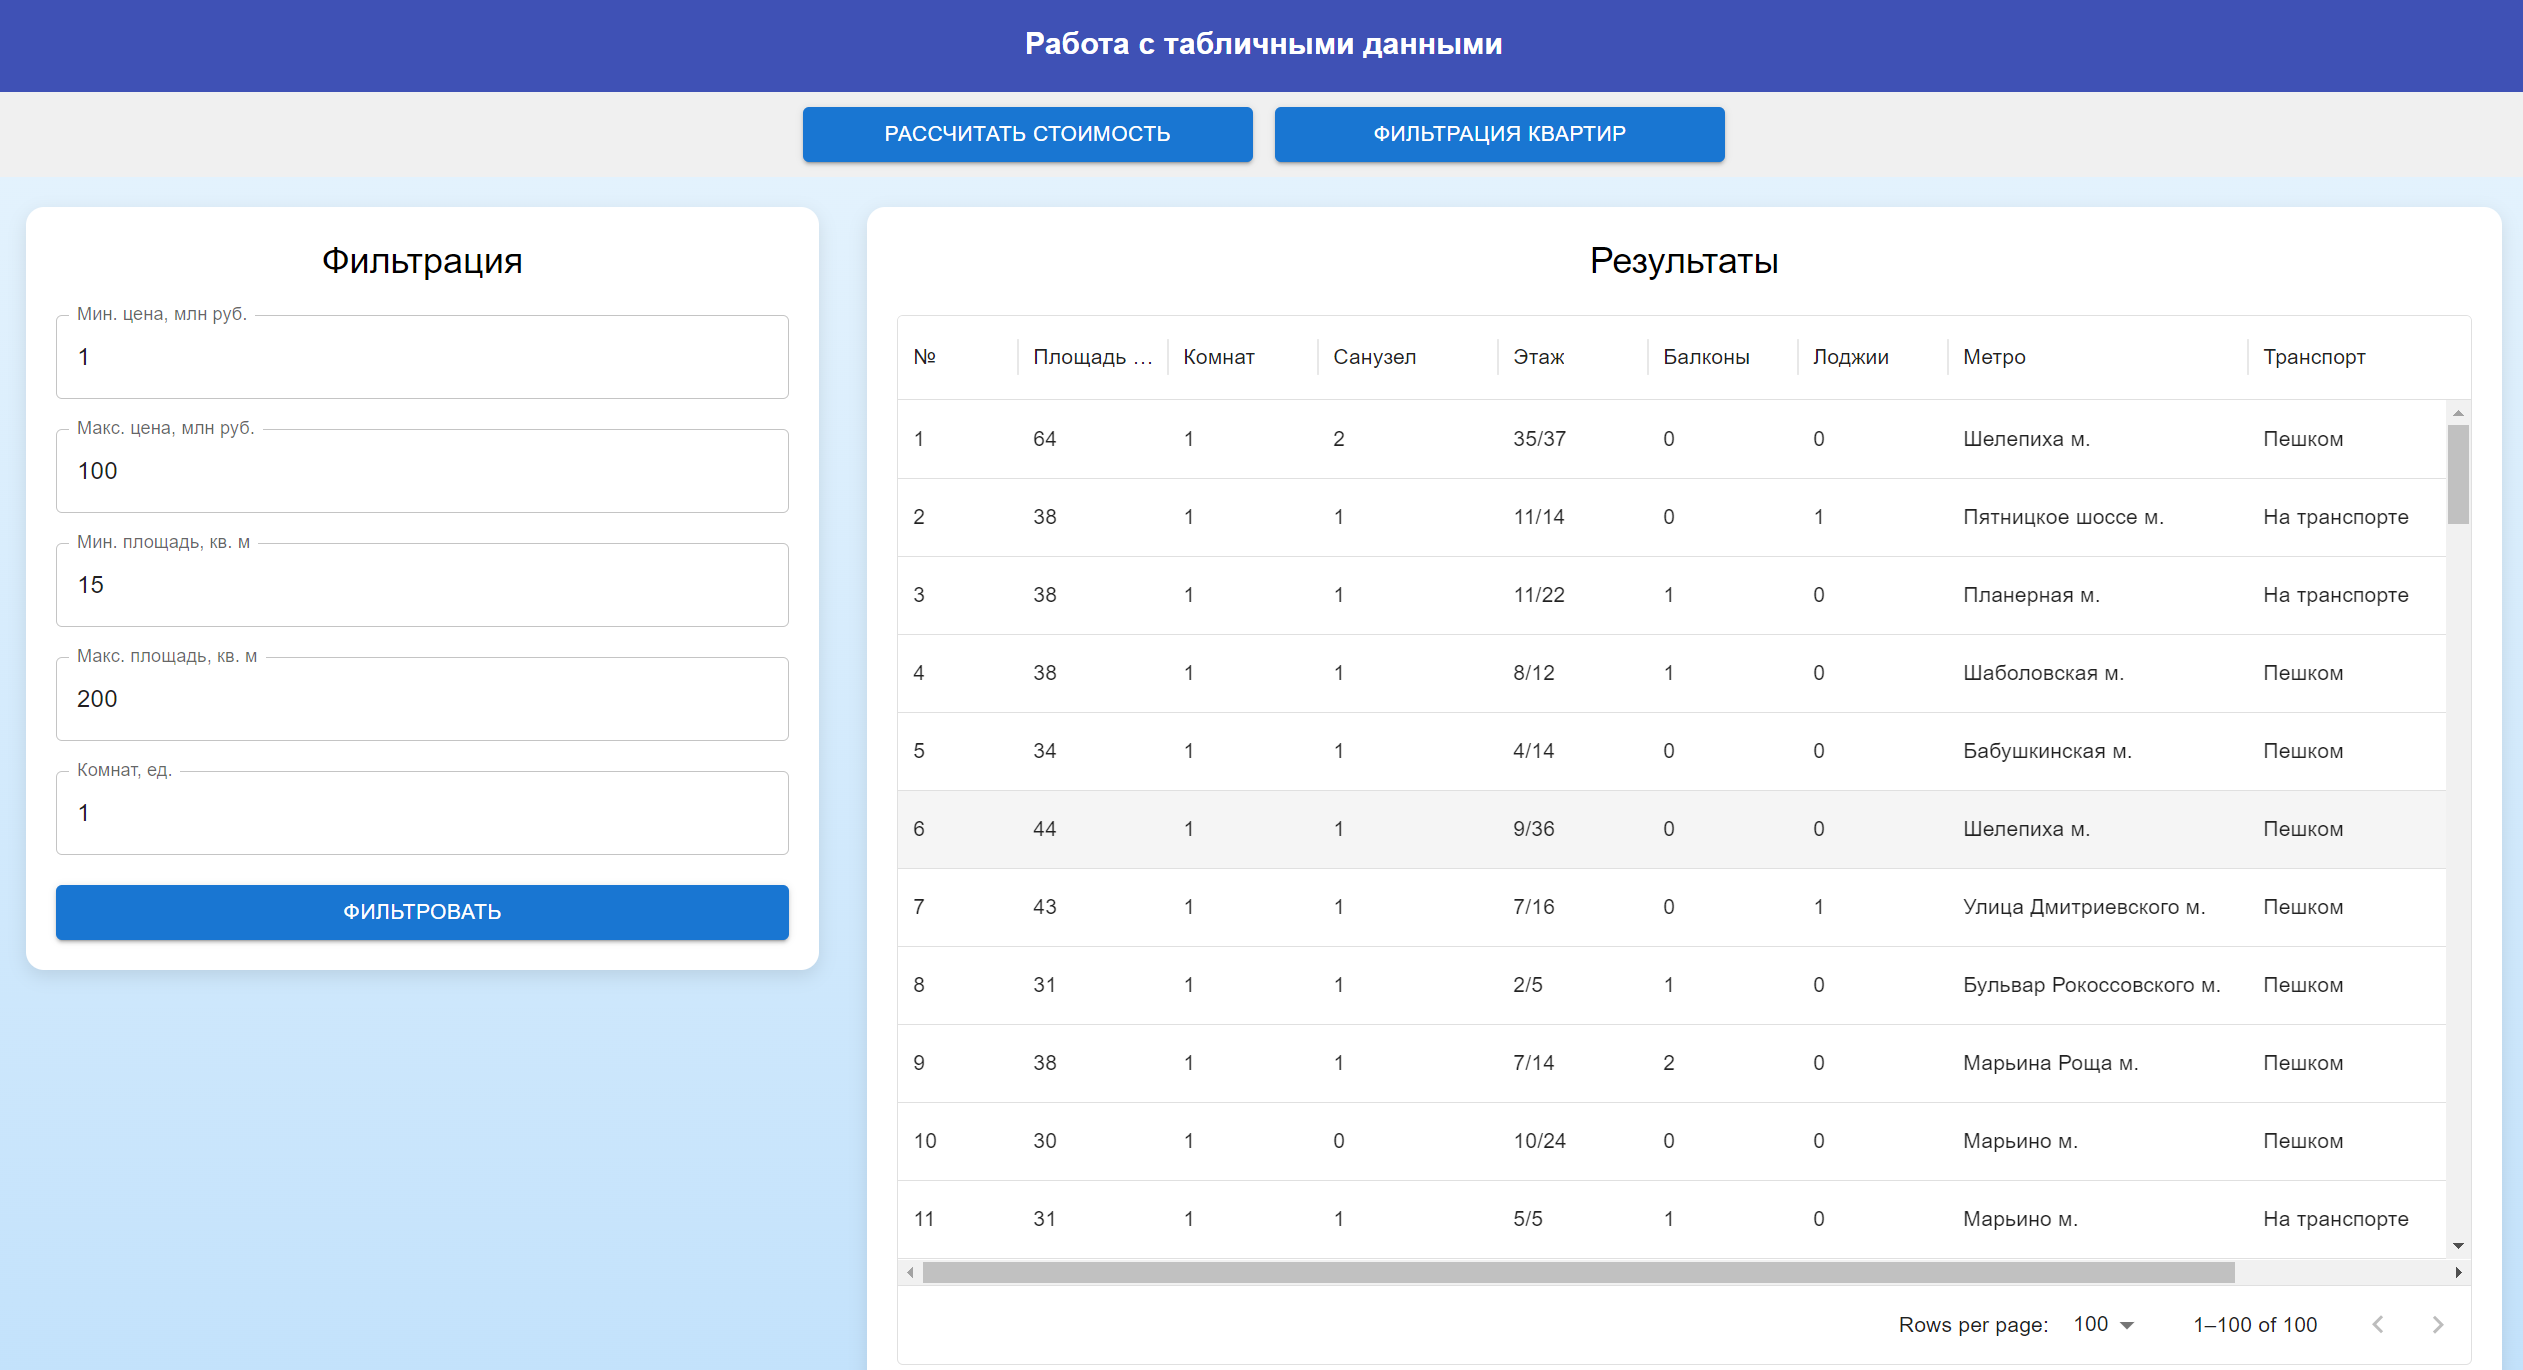

### **Описание структуры проекта**

#### Структура React-сервера

1. **Приложение React (`react-app`)**:
   - **`src/App.js`**: Основной компонент, обеспечивающий пользовательский интерфейс (поиск квартир, отправка параметров для предсказания цены, отображение результата).
   - **`src/styles.css`**: Стили приложения
   - **Дополнительные компоненты**: Возможность разделения функциональности на отдельные компоненты (прогнозированеи цены, фильрация данных).

2. **Функциональность**:
   - **Форма ввода данных**: Пользователь заполняет параметры квартиры (площадь, этаж, количество комнат, тип дома и т.д.) или (минимальное значение цены, максимальное значение цены и т.д.).
   - **API-запросы к Django**: Отправка параметров на сервер и получение предсказанной цены.
   - **Отображение результатов**: После отправки данных, на экране выводится предсказанная цена квартиры или отфильтрованные данные с возможностью сортировки.
   - **Гибкий дизайн**: Адаптивный интерфейс для разных устройств (мобильные, планшеты, десктопы).



#### Структура Django-сервера

1. **Проект Django (`myproject`)**:
   - **`settings.py`**: Настройки проекта:
     - Конфигурация CORS для взаимодействия с фронтендом.
     - Настройка обработки и хранения статических файлов.
     - Логирование запросов, ошибок и результатов обработки.
   - **`urls.py`**: Основные маршруты проекта, включая подключение маршрутов приложения `flatprocessor`.

2. **Приложение (`flatprocessor`)**:
   - **`views.py`**:
     - Логика обработки данных о квартирах:
       - Получение параметров от клиента (например, площадь, этаж, тип дома).
       - Выполнение предсказания цены на основе модели машинного обучения.
       - Фильтрация квартир по заданным параметрам.
     - Формирование и отправка ответа клиенту.
   - **`urls.py`**:
     - Локальные маршруты приложения:
       - **`/api/flats/predict/`**: Маршрут для предсказания цены квартиры.
       - **`/api/flats/filter/`**: Маршрут для фильтрации квартир по заданным критериям.

3. **Логирование**:
   - **`django_requests.log`**: Логирование:
     - Запросов от React-приложения.
     - Результатов обработки данных.
     - Ошибок и исключений.

4. **Ngrok**:
   - Проброс локального Django-сервера в интернет для интеграции с React.
   - Генерация публичного URL для удаленного взаимодействия с бэкендом.
   - Обеспечение быстрого тестирования и демонстрации функциональности.


#### Связь между серверами

React отправляет запросы на Django (`/api/flats/predict/`, /api/flats/filter/), которые обрабатывают входные данные, выполняют фильтрацию по заданным параметрам и предсказание стоимости квартиры на основе обученной модели. Django возвращает результаты: список подходящих квартир с их характеристиками и предсказанную стоимость.

React отображает полученные данные в удобном интерфейсе.




### **Запуск проекта (ПЕРЕД ЗАПУСКОМ РЕКОМЕНДУЕТСЯ УДАЛИТЬ ТЕКУЩУЮ СРЕДУ В МЕНЮ GOOGLE COLAB ДЛЯ ПОЛНОЙ ОЧИСТКИ ДАННЫХ ПОД ПРОЕКТ)**

In [ ]:
# @title ОСТАНОВКА ВСЕХ ПРОЦЕССОВ (ИНИЦИИРОВАТЬ ПЕРЕД КАЖДЫМ ТЕСТИРОВАНИЕМ)
!pkill -f manage.py
!pkill -f ngrok
!pkill -f npm

In [ ]:
# @title Установка Django-сервера и React-сервера
!pip install django
!pip install django-cors-headers
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pyngrok
!pip install autokeras

import os
import re
import json
from django.http import JsonResponse
from django.views.decorators.csrf import csrf_exempt
import pandas as pd
from sklearn.linear_model import LinearRegression
from pyngrok import ngrok
from google.colab import userdata
import gdown  # Убедитесь, что библиотека установлена

# Переходим в папку проекта и создаём Django проект
!django-admin startproject myproject
%cd /content/myproject
!python manage.py startapp flatprocessor

# Создаём папку для данных внутри проекта
data_folder = "/content/myproject/data"
os.makedirs(data_folder, exist_ok=True)

# Загружаем файл с таблицей прямо в папку проекта
URL = 'https://storage.yandexcloud.net/terraai/sources/flats.zip'
download_filename = gdown.download(URL, None, quiet=True)
!unzip -q {download_filename} -d {data_folder}
!rm -rf {download_filename}

# Создаем файл логов заранее
!touch /content/myproject/django_requests.log

# Настроим Ngrok для туннелирования
ngrok_key = userdata.get("NGROK_KEY")
ngrok.set_auth_token(ngrok_key)

# Установка React и Material-UI
!curl -fsSL https://deb.nodesource.com/setup_18.x | bash -
!apt-get install -y nodejs
!npx --yes create-react-app react-app
%cd react-app
!npm install axios
!npm install @mui/material @emotion/react @emotion/styled
!npm install react-router-dom
!npm install @mui/x-data-grid

# Создаём папку для статических файлов
!mkdir -p /content/myproject/static

import zipfile
import os

# Ссылка на ZIP-архив с моделью и scaler'ами
zip_url = 'https://drive.google.com/uc?id=1D_MDxb5qgnSjwK-txzf9ima5vdVRbvNw'

# Скачиваем ZIP-архив
output = '/content/flat_model.zip'
gdown.download(zip_url, output, quiet=False)

# Создаем директорию для модели
os.makedirs('/content/myproject/static/model', exist_ok=True)

# Распаковываем ZIP с обработкой русских символов
with zipfile.ZipFile(output, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        filename = file_info.filename.encode('cp437').decode('utf-8')  # Исправляем кодировку
        file_info.filename = filename
        zip_ref.extract(file_info, '/content/myproject/static/model')

print("Модель и масштабировщики успешно распакованы!")

def start_react_server():
    """Функция для запуска React-приложения на порту 3000 с использованием Ngrok."""
    # Остановка запущенных процессов
    os.system("pkill -f manage.py")
    os.system("pkill -f ngrok")

    # Запуск React-приложения в фоновом режиме
    os.system("nohup npm start > react_output.log 2>&1 &")

    try:
        # Настройка Ngrok для проброса порта 3000
        public_url2 = ngrok.connect(3000)
        print(f"React-приложение доступно по адресу:")
        return public_url2
    except Exception as e:
        print(f"Ошибка при подключении Ngrok: {e}")
        return None


def start_django_server():
    """Функция для запуска Django-сервера в фоновом режиме."""
    # Перемещаемся в директорию проекта
    os.chdir("/content/myproject")

    # Применяем миграции базы данных
    os.system("nohup python manage.py migrate > migrate.log 2>&1")

    # Запускаем Django-сервер в фоновом режиме
    os.system("nohup python manage.py runserver 0.0.0.0:8000 > django.log 2>&1 &")

    # Настраиваем Ngrok для проброса порта 8000
    public_url = ngrok.connect(8000)
    print(f"Django-приложение доступно по адресу: {public_url}")

    return public_url

# Обновление файл settings.py с новыми настройками
# Путь к файлу settings.py
file_path = "/content/myproject/myproject/settings.py"

# Читаем содержимое файла settings.py
with open(file_path, "r") as file:
    content = file.read()

# Извлекаем значение SECRET_KEY
secret_key_match = re.search(r'SECRET_KEY\s*=\s*[\'"](.+?)[\'"]', content)
if secret_key_match:
    secret_key = secret_key_match.group(1)
else:
    raise ValueError("SECRET_KEY не найден в файле.")

# Новое содержимое settings.py
text_s = f"""
SECRET_KEY = '{secret_key}'

from pathlib import Path
import os

BASE_DIR = Path(__file__).resolve().parent.parent

DEBUG = True

ALLOWED_HOSTS = ['*']  # Разрешить запросы с любых хостов

INSTALLED_APPS = [
    'corsheaders',  # Добавить приложение для обработки CORS
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    'flatprocessor',  # Приложение для обработки данных о квартирах
]

MIDDLEWARE = [
    'corsheaders.middleware.CorsMiddleware',  # CORS обработчик
    'django.middleware.common.CommonMiddleware',
    'django.middleware.security.SecurityMiddleware',
    'django.contrib.sessions.middleware.SessionMiddleware',
    'django.middleware.csrf.CsrfViewMiddleware',
    'django.contrib.auth.middleware.AuthenticationMiddleware',
    'django.contrib.messages.middleware.MessageMiddleware',
    'django.middleware.clickjacking.XFrameOptionsMiddleware',
]

DATA_UPLOAD_MAX_MEMORY_SIZE = 10485760  # 10MB

CORS_ALLOW_ALL_ORIGINS = True  # Разрешить запросы с любых доменов
CORS_ALLOW_METHODS = ['GET', 'POST', 'OPTIONS']  # Разрешенные HTTP методы
CORS_ALLOW_HEADERS = ['content-type', 'authorization']  # Разрешенные заголовки

ROOT_URLCONF = 'myproject.urls'

TEMPLATES = [
    {{
        'BACKEND': 'django.template.backends.django.DjangoTemplates',
        'DIRS': [BASE_DIR / 'templates'],  # Папка для шаблонов, если нужна
        'APP_DIRS': True,
        'OPTIONS': {{
            'context_processors': [
                'django.template.context_processors.debug',
                'django.template.context_processors.request',  # Это важно для админки
                'django.contrib.auth.context_processors.auth',
                'django.contrib.messages.context_processors.messages',
            ],
        }},
    }},
]

WSGI_APPLICATION = 'myproject.wsgi.application'

DATABASES = {{
    'default': {{
        'ENGINE': 'django.db.backends.sqlite3',
        'NAME': BASE_DIR / 'db.sqlite3',
    }}
}}

AUTH_PASSWORD_VALIDATORS = [
    {{
        'NAME': 'django.contrib.auth.password_validation.UserAttributeSimilarityValidator',
    }},
    {{
        'NAME': 'django.contrib.auth.password_validation.MinimumLengthValidator',
    }},
    {{
        'NAME': 'django.contrib.auth.password_validation.CommonPasswordValidator',
    }},
    {{
        'NAME': 'django.contrib.auth.password_validation.NumericPasswordValidator',
    }},
]

LANGUAGE_CODE = 'en-us'

TIME_ZONE = 'UTC'

USE_I18N = True

USE_TZ = True

LOGGING = {{
    'version': 1,
    'disable_existing_loggers': True,  # Полностью отключить все стандартные логеры Django
    'formatters': {{
        'verbose': {{
            'format': '{{levelname}} {{asctime}} {{module}} {{message}}',
            'style': '{{',
        }},
    }},
    'handlers': {{
        'file': {{
            'level': 'INFO',  # Логируются только сообщения уровня INFO и выше
            'class': 'logging.FileHandler',
            'filename': os.path.join(BASE_DIR, 'django_requests.log'),
            'formatter': 'verbose',
        }},
    }},
    'loggers': {{
        'views': {{  # Логирование только из views.py
            'handlers': ['file'],
            'level': 'INFO',  # Логируются только сообщения уровня INFO и выше
            'propagate': False,  # Не передавать логи другим логгерам
        }},
    }},
}}

STATIC_URL = '/static/'
MEDIA_URL = '/media/'
MEDIA_ROOT = BASE_DIR / 'static/uploads'

# Если вы используете статику в разработке, укажите путь к папке
STATICFILES_DIRS = [os.path.join(BASE_DIR, 'static')]

# Для продакшн-окружения
STATIC_ROOT = BASE_DIR / 'staticfiles'

DEFAULT_AUTO_FIELD = 'django.db.models.BigAutoField'
"""

# Перезаписываем файл settings.py с новыми настройками
with open(file_path, "w") as file:
    file.write(text_s)

# @title Обновление маршрутов для Django

# Переход в директорию проекта
%cd /content/myproject

# Создание папки для приложения flatprocessor, если её нет
os.makedirs('/content/myproject/flatprocessor', exist_ok=True)

# Создание файла urls.py в приложении flatprocessor
flatprocessor_urls_path = "/content/myproject/flatprocessor/urls.py"
with open(flatprocessor_urls_path, 'w') as f:
    f.write("""
from django.urls import path
from .views import predict_price, filter_flats  # Импортируем правильный обработчик

urlpatterns = [
    path('flats/predict/', predict_price, name='predict_price'),  # Указываем маршрут для предсказания цены
    path('flats/filter/', filter_flats, name='filter_flats'),  # Указываем маршрут для фильтрации квартир
]
""")
print("Файл urls.py для приложения flatprocessor создан или обновлён.")

# Обновление основного файла urls.py проекта
project_urls_path = "/content/myproject/myproject/urls.py"
urls_content = """
from django.contrib import admin
from django.urls import path, include

urlpatterns = [
    path('api/', include('flatprocessor.urls')),  # Подключаем маршруты из файла flatprocessor/urls.py
    path('admin/', admin.site.urls),  # Маршрут для панели администратора
]
"""

with open(project_urls_path, "w") as file:
    file.write(urls_content)

print("Файл urls.py для проекта обновлён.")

# Создание файла views.py в приложении flatprocessor, если его нет
flatprocessor_views_path = "/content/myproject/flatprocessor/views.py"
if not os.path.exists(flatprocessor_views_path):
    with open(flatprocessor_views_path, 'w') as f:
        f.write("""
from django.http import JsonResponse

def process_flats(request):
    return JsonResponse({"message": "Обработчик пока не настроен"})
""")
    print("Файл views.py для приложения flatprocessor создан.")
else:
    print("Файл views.py для приложения flatprocessor уже существует.")

def update_react_component_with_new_url(public_url):
    # Переходим в папку сервера react
    %cd /content/myproject/react-app

    # Извлечение URL с использованием регулярного выражения
    public_url_str = str(public_url)
    match = re.search(r'https://[^\s"]+', public_url_str)

    if match:
        link_r = match.group(0)
    else:
        print("URL не найден.")
        return

    # Создаем новый React-компонент с актуальным адресом
    text_ob_react = f"""
import React, {{ useState }} from "react";
import "./styles.css"; // Подключаем файл стилей
import {{ BrowserRouter as Router, Route, Routes, Link }} from "react-router-dom";
import {{ Grid, Box, Button, Typography, TextField, Select, MenuItem, AppBar, Toolbar}} from "@mui/material";
import {{ DataGrid }} from '@mui/x-data-grid';
import {{ FormControl, InputLabel }} from "@mui/material";
function App() {{
  return (
    <Router>
      <Box sx={{{{ flexGrow: 1 }}}}>
        {{/* Верхнее меню */}}
        <AppBar position="static" sx={{{{ background: "#3f51b5" }}}}>
          <Toolbar>
            <Typography
              variant="h6"
              sx={{{{
                flexGrow: 1,
                textAlign: "center",
                fontWeight: "bold",
              }}}}
            >
              Работа с табличными данными
            </Typography>
          </Toolbar>
        </AppBar>

        {{/* Навигация */}}
        <Box
          sx={{{{
            display: "flex",
            justifyContent: "center",
            background: "#f0f0f0",
            padding: "10px",
          }}}}
        >
          <Link
            to="/"
            style={{{{
              textDecoration: "none",
              marginRight: "15px",
            }}}}
          >
            <Button variant="contained" color="primary" sx={{{{minWidth: "300px"}}}}>
              Рассчитать стоимость
            </Button>
          </Link>
          <Link
            to="/filter"
            style={{{{
              textDecoration: "none",
            }}}}
          >
            <Button variant="contained" color="primary" sx={{{{minWidth: "300px"}}}}>
              Фильтрация квартир
            </Button>
          </Link>
        </Box>

        {{/* Основное содержимое */}}
        <Routes>
          <Route path="/" element={{<PredictionPage />}} />
          <Route path="/filter" element={{<FilterPage />}} />
        </Routes>
      </Box>
    </Router>
  );
}}

function PredictionPage() {{
  const [formData, setFormData] = useState({{
    area: "40",
    rooms: "1",
    bathroom: "1",
    floor: "1",
    totalFloors: "12",
    balconies: "0",
    loggias: "0",
    metro: "Станция метро",
    transportType: "Как добраться"
  }});
  const transportTypes = ["Пешком", "На транспорте", "Не указано"];
  const metroStations = [
    "Шелепиха м.", "Пятницкое шоссе м.", "Планерная м.", "Шаболовская м.",
    "Бабушкинская м.", "Улица Дмитриевского м.", "Бульвар Рокоссовского м.",
    "Марьина Роща м.", "Марьино м.", "Печатники м.", "Красногвардейская м.",
    "Площадь Ильича м.", "Славянский бульвар м.", "Раменки м.", "Ботанический сад м.",
    "Маяковская м.", "Хорошево м. (МЦК)", "Проспект Вернадского м.", "Серпуховская м.",
    "Улица Академика Янгеля м.", "Крылатское м.", "Первомайская м.", "Измайловская м.",
    "Мичуринский проспект м.", "Бульвар Дмитрия Донского м.", "Коптево м. (МЦК)",
    "Ростокино м. (МЦК)", "Саларьево м.", "Октябрьское поле м.", "Фрунзенская м.",
    "Спортивная м.", "Царицыно м.", "Арбатская м.", "Юго-Западная м.", "Белокаменная м. (МЦК)",
    "Молодежная м.", "Медведково м.", "Кунцевская м.", "Авиамоторная м.", "Тимирязевская м.",
    "Столбово м.", "Селигерская м.", "Коньково м.", "Бунинская аллея м.", "Теплый стан м.",
    "Ломоносовский проспект м.", "Люблино м.", "Электрозаводская м.", "Перово м.",
    "Бауманская м.", "Автозаводская м.", "Прокшино м.", "Севастопольская м.",
    "Новые Черемушки м.", "Сходненская м.", "Братиславская м.", "Аннино м.",
    "Ховрино м.", "Преображенская площадь м.", "Новокосино м.", "Новопеределкино м.",
    "Спартак м.", "Беломорская м.", "Тропарево м.", "Академическая м.", "Строгино м.",
    "Выхино м.", "Тульская м.", "Говорово м.", "Текстильщики м.", "ЗИЛ м. (МЦК)",
    "Домодедовская м.", "Коломенская м.", "Борисово м.", "Волжская м.",
    "Улица Скобелевская м.", "Улица 1905 года м.", "Андроновка м. (МЦК)",
    "Нижегородская м. (МЦК)", "Рассказовка м.", "Отрадное м.", "Окружная м.",
    "Рязанский проспект м.", "Свиблово м.", "Солнцево м.", "Сокол м.", "Крымская м. (МЦК)",
    "Выставочная м.", "Румянцево м.", "Ясенево м.", "Смоленская м.", "Новохохловская м. (МЦК)",
    "Боровское шоссе м.", "Шипиловская м.", "Аэропорт м.", "Щелковская м.", "ВДНХ м.",
    "Южная м.", "Профсоюзная м.", "Волгоградский проспект м.", "Лесопарковая м.",
    "Кропоткинская м.", "Окская улица м.", "Пролетарская м.", "Стахановская м.",
    "Озерная м.", "Ольховая м.", "Филатов луг м.", "Новогиреево м.",
    "Петровско-Разумовская м.", "Некрасовка м.", "Калужская м.",
    "Площадь Гагарина м. (МЦК)", "Лухмановская м.", "Белорусская м.",
    "Кантемировская м.", "Бульвар Рокоссовского м. (МЦК)", "Улица Горчакова м.",
    "Красносельская м.", "Бибирево м.", "Фили м.", "Владыкино м.", "Алексеевская м.",
    "Волоколамская м.", "Новослободская м.", "Угрешская м. (МЦК)", "Курская м.",
    "Лихоборы м. (МЦК)", "Кузьминки м.", "ЦСКА м.", "Лермонтовский проспект м.",
    "Алтуфьево м.", "Динамо м.", "Краснопресненская м.", "Дмитровская м.",
    "Соколиная Гора м. (МЦК)", "Шоссе Энтузиастов м.", "Семеновская м.",
    "Чистые пруды м.", "Красные ворота м.", "Нахимовский проспект м.", "Орехово м.",
    "Технопарк м.", "Бутырская м.", "Студенческая м.", "Щукинская м.", "Жулебино м.",
    "Чкаловская м.", "Фонвизинская м.", "Новоясеневская м.",
    "Улица Старокачаловская м.", "Речной вокзал м.", "Митино м.",
    "Юго-Восточная м.", "Сокольники м.", "Петровский парк м.", "Пражская м.",
    "Университет м.", "Панфиловская м. (МЦК)", "Автозаводская м. (МЦК)",
    "Войковская м.", "Беляево м.", "Киевская м.", "Черкизовская м.", "Стрешнево м. (МЦК)",
    "Тушинская м.", "Тверская м.", "Варшавская м.", "Таганская м.", "Китай-Город м.",
    "Римская м.", "Балтийская м. (МЦК)", "Чертановская м.", "Каховская м.",
    "Бульвар Адмирала Ушакова м.", "Полежаевская м.", "Беговая м.",
    "Дубровка м. (МЦК)", "Парк культуры м.", "Новокузнецкая м.",
    "Парк Победы м.", "Воробьевы Горы м.", "Водный стадион м.", "Победа станция",
    "Достоевская м.", "Кожуховская м.", "Савеловская м.", "Марксистская м.",
    "Окружная м. (МЦК)", "Алма-Атинская м.", "Зорге м. (МЦК)", "Менделеевская м.",
    "Хорошевское м.", "Нагорная м.", "Крекшино станция", "Комсомольская м.",
    "Партизанская м.", "Локомотив м. (МЦК)", "Октябрьская м.", "Савеловская метро",
    "Измайлово м. (МЦК)", "Верхние Лихоборы м.", "Каширская м.", "Пушкинская м.",
    "Филевский парк м.", "Павелецкая м.", "Кутузовская м.", "Минская м.",
    "Баррикадная м.", "Библиотека им.Ленина м.", "Зябликово м.", "Не Указано"
  ];

  const [predictedPrice, setPredictedPrice] = useState(null);
  const [isProcessing, setIsProcessing] = useState(false);

  const handleChange = (e) => {{
    const {{ name, value }} = e.target;
    setFormData((prevData) => ({{
      ...prevData,
      [name]: value
    }}));
  }};

  const handleSubmit = async (e) => {{
    e.preventDefault();

  const {{ area, rooms, bathroom, floor, totalFloors, balconies, loggias, metro, transportType }} = formData;

  if (
    !area ||
    !rooms ||
    !bathroom ||
    !floor ||
    !totalFloors ||
    !balconies ||
    !loggias ||
    !metro ||
    !transportType
  ) {{
    alert("Пожалуйста, заполните все поля.");
    return;
  }}

    setIsProcessing(true);
    try {{
      const form = new FormData();
      form.append("Площадь", parseFloat(area));
      form.append("Комнат", parseInt(rooms, 10));
      form.append("Санузел", parseInt(bathroom, 10));
      form.append("Этаж", parseInt(floor, 10));
      form.append("Всего этажей в доме", parseInt(totalFloors, 10));
      form.append("Балконы", parseInt(balconies, 10) || 0);
      form.append("Лоджии", parseInt(loggias, 10) || 0);
      form.append("Станция метро", metro);
      form.append("Пешком или на транспорте", transportType);

      const response = await fetch(`{link_r}/api/flats/predict/`, {{
        method: "POST",
        body: form,
      }});

      if (!response.ok) {{
        throw new Error("Ошибка сервера.");
      }}

      const data = await response.json();
      setPredictedPrice((data.predicted_price).toFixed(2));
    }} catch (error) {{
      alert("Произошла ошибка: " + error.message);
    }} finally {{
      setIsProcessing(false);
    }}
  }};

  return (
    <Box
      sx={{{{
        background: "linear-gradient(180deg, #e3f2fd, #bbdefb)",
        height: "100vh",
        padding: "20px"
      }}}}
    >
      <Grid container spacing={{4}}>
        <Grid item xs={{12}} md={{4}}>
          <Box
            sx={{{{
              background: "#fff",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)"
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Ввод данных о квартире
            </Typography>
            <TextField
              label="Площадь (м²)"
              name="area"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.area}}
              onChange={{handleChange}}
            />
            <TextField
              label="Комнаты, шт."
              name="rooms"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.rooms}}
              onChange={{handleChange}}
            />
            <TextField
              label="Санузлы, шт."
              name="bathroom"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.bathroom}}
              onChange={{handleChange}}
            />
            <TextField
              label="Этаж"
              name="floor"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.floor}}
              onChange={{handleChange}}
            />
            <TextField
              label="Этажей в доме"
              name="totalFloors"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.totalFloors}}
              onChange={{handleChange}}
            />
            <TextField
              label="Балконы, шт."
              name="balconies"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.balconies}}
              onChange={{handleChange}}
            />
            <TextField
              label="Лоджии, шт."
              name="loggias"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.loggias}}
              onChange={{handleChange}}
            />
            <FormControl fullWidth sx={{{{ marginBottom: "20px" }}}}>
              <InputLabel id="metro-label">Станция метро</InputLabel>
              <Select
                label="Станция метро"
                name="metro"
                value={{formData.metro}}
                fullWidth
                variant="outlined"
                sx={{{{ marginBottom: "20px" }}}}
                onChange={{handleChange}}
              >
                <MenuItem value="">
                  <em>Станция метро</em>
                </MenuItem>
                {{metroStations.map((station) => (
                  <MenuItem key={{station}} value={{station}}>
                    {{station}}
                  </MenuItem>
                ))}}
              </Select>
            </FormControl>
            <FormControl fullWidth sx={{{{ marginBottom: "20px" }}}}>
              <InputLabel id="transport-label">Тип передвижения</InputLabel>
              <Select
                label="Тип передвижения"
                name="transportType"
                value={{formData.transportType}}
                fullWidth
                variant="outlined"
                sx={{{{ marginBottom: "20px" }}}}
                onChange={{handleChange}}
              >
                <MenuItem value="">
                  <em>Как добраться</em>
                </MenuItem>
                {{transportTypes.map((type) => (
                  <MenuItem key={{type}} value={{type}}>
                    {{type}}
                  </MenuItem>
                ))}}
              </Select>
            </FormControl>
            <Button
              onClick={{handleSubmit}}
              disabled={{isProcessing}}
              variant="contained"
              color="primary"
              fullWidth
            >
              {{isProcessing ? "Обрабатываем..." : "Рассчитать стоимость"}}
            </Button>
          </Box>
        </Grid>
        <Grid item xs={{12}} md={{8}}>
          <Box
            sx={{{{
              background: "#fff",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)"
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Результаты
            </Typography>
            {{predictedPrice !== null ? (
              <Typography variant="h6">
                <strong>Предсказанная стоимость:</strong> {{predictedPrice}} млн руб.
              </Typography>
            ) : (
              <Typography variant="body1">Результаты отсутствуют.</Typography>
            )}}
          </Box>
        </Grid>
      </Grid>
    </Box>
  );
}}

function FilterPage() {{
  const [formData, setFormData] = useState({{
    minPrice: "1",
    maxPrice: "100",
    minArea: "15",
    maxArea: "200",
    rooms: "1"
  }});
  const [results, setResults] = useState([]);
  const [isProcessing, setIsProcessing] = useState(false);
  const [tableData, setTableData] = useState([]); // Данные для таблицы

  const handleChange = (e) => {{
    const {{ name, value }} = e.target;
    setFormData((prevData) => ({{
      ...prevData,
      [name]: value
    }}));
  }};

  const handleSubmit = async (e) => {{
    e.preventDefault();

    const {{ minPrice, maxPrice, minArea, maxArea, rooms }} = formData;
    if (!minPrice || !maxPrice || !minArea || !maxArea || !rooms) {{
      alert("Пожалуйста, заполните все поля.");
      return;
    }}

    setIsProcessing(true);
    try {{
      const form = new FormData();
      form.append("minPrice", parseFloat(minPrice));
      form.append("maxPrice", parseFloat(maxPrice));
      form.append("minArea", parseFloat(minArea));
      form.append("maxArea", parseFloat(maxArea));
      form.append("rooms", parseInt(rooms, 10));

      const response = await fetch(`{link_r}/api/flats/filter/`, {{
        method: "POST",
        body: form,
      }});

      if (!response.ok) {{
        throw new Error("Ошибка сервера.");
      }}

      const data = await response.json();
      setResults(data.results);
      parseTableData(data.results);  // Преобразуем строки в таблицу
    }} catch (error) {{
      alert("Произошла ошибка: " + error.message);
    }} finally {{
      setIsProcessing(false);
    }}
  }};

  // Парсинг строк в формат таблицы
  const parseTableData = (results) => {{
    const parsedData = results.map((item, index) => {{
      const regex = /Площадь: (\d+) м², Комнат: (\d+), Санузел: (\d+), Этаж: (\d+)\/(\d+), Балконы: (\d+), Лоджии: (\d+), Метро: (.+?), Транспорт: (.+?), Цена: ([\d.]+) млн руб./;
      const match = item.match(regex);

      if (match) {{
        return {{
          id: index + 1,
          area: match[1],
          rooms: match[2],
          bathroom: match[3],
          floor: `${{match[4]}}/${{match[5]}}`,
          balconies: match[6],
          loggias: match[7],
          metro: match[8],
          transport: match[9],
          price: `${{match[10]}} млн руб.`
        }};
      }}
      return null;
    }}).filter(Boolean);

    setTableData(parsedData);
  }};

  const columns = [
    {{ field: "id", headerName: "№", width: 80 }},
    {{ field: "area", headerName: "Площадь (м²)", width: 100 }},
    {{ field: "rooms", headerName: "Комнат", width: 100 }},
    {{ field: "bathroom", headerName: "Санузел", width: 120 }},
    {{ field: "floor", headerName: "Этаж", width: 100 }},
    {{ field: "balconies", headerName: "Балконы", width: 100 }},
    {{ field: "loggias", headerName: "Лоджии", width: 100 }},
    {{ field: "metro", headerName: "Метро", width: 200 }},
    {{ field: "transport", headerName: "Транспорт", width: 150 }},
    {{ field: "price", headerName: "Цена", width: 150 }},
  ];

  return (
    <Box
      sx={{{{
        background: "linear-gradient(180deg, #e3f2fd, #bbdefb)",
        height: "100vh",
        padding: "20px"
      }}}}
    >
      <Grid container spacing={{4}}>
        <Grid item xs={{12}} md={{4}}>
          <Box
            sx={{{{
              background: "#fff",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)"
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Фильтрация
            </Typography>
            <TextField
              label="Мин. цена, млн руб."
              name="minPrice"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.minPrice}}
              onChange={{handleChange}}
            />
            <TextField
              label="Макс. цена, млн руб."
              name="maxPrice"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.maxPrice}}
              onChange={{handleChange}}
            />
            <TextField
              label="Мин. площадь, кв. м"
              name="minArea"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.minArea}}
              onChange={{handleChange}}
            />
            <TextField
              label="Макс. площадь, кв. м"
              name="maxArea"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.maxArea}}
              onChange={{handleChange}}
            />
            <TextField
              label="Комнат, ед."
              name="rooms"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.rooms}}
              onChange={{handleChange}}
            />
            <Button
              onClick={{handleSubmit}}
              disabled={{isProcessing}}
              variant="contained"
              color="primary"
              fullWidth
            >
              {{isProcessing ? "Обрабатываем..." : "Фильтровать"}}
            </Button>
          </Box>
        </Grid>
        <Grid item xs={{12}} md={{8}}>
          <Box
            sx={{{{
              background: "#fff",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)"
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Результаты
            </Typography>
            <div style={{{{ height: 700, width: "100%" }}}}>
              <DataGrid
                rows={{tableData}}
                columns={{columns}}
                pageSize={{10}}
                rowsPerPageOptions={{[10, 20]}}
                loading={{isProcessing}}
              />
            </div>
          </Box>
        </Grid>
      </Grid>
    </Box>
  );
}}

export default App;
"""

    # Сохраняем обновленный файл App.js
    with open("src/App.js", "w") as file:
        file.write(text_ob_react)
    print("React компонент успешно обновлен с новым адресом.")

# Переходим в папку сервера react
%cd /content/myproject/react-app

# Создаем динамическую ссылку
link_r = ""

text_ob_react = f"""
import React, {{ useState }} from "react";
import "./styles.css"; // Подключаем файл стилей
import {{ BrowserRouter as Router, Route, Routes, Link }} from "react-router-dom";
import {{ Grid, Box, Button, Typography, TextField, Select, MenuItem, AppBar, Toolbar}} from "@mui/material";
import {{ DataGrid }} from '@mui/x-data-grid';
import {{ FormControl, InputLabel }} from "@mui/material";
function App() {{
  return (
    <Router>
      <Box sx={{{{ flexGrow: 1 }}}}>
        {{/* Верхнее меню */}}
        <AppBar position="static" sx={{{{ background: "#3f51b5" }}}}>
          <Toolbar>
            <Typography
              variant="h6"
              sx={{{{
                flexGrow: 1,
                textAlign: "center",
                fontWeight: "bold",
              }}}}
            >
              Работа с табличными данными
            </Typography>
          </Toolbar>
        </AppBar>

        {{/* Навигация */}}
        <Box
          sx={{{{
            display: "flex",
            justifyContent: "center",
            background: "#f0f0f0",
            padding: "10px",
          }}}}
        >
          <Link
            to="/"
            style={{{{
              textDecoration: "none",
              marginRight: "15px",
            }}}}
          >
            <Button variant="contained" color="primary" sx={{{{minWidth: "300px"}}}}>
              Рассчитать стоимость
            </Button>
          </Link>
          <Link
            to="/filter"
            style={{{{
              textDecoration: "none",
            }}}}
          >
            <Button variant="contained" color="primary" sx={{{{minWidth: "300px"}}}}>
              Фильтрация квартир
            </Button>
          </Link>
        </Box>

        {{/* Основное содержимое */}}
        <Routes>
          <Route path="/" element={{<PredictionPage />}} />
          <Route path="/filter" element={{<FilterPage />}} />
        </Routes>
      </Box>
    </Router>
  );
}}

function PredictionPage() {{
  const [formData, setFormData] = useState({{
    area: "40",
    rooms: "1",
    bathroom: "1",
    floor: "1",
    totalFloors: "12",
    balconies: "0",
    loggias: "0",
    metro: "Станция метро",
    transportType: "Как добраться"
  }});
  const transportTypes = ["Пешком", "На транспорте", "Не указано"];
  const metroStations = [
    "Шелепиха м.", "Пятницкое шоссе м.", "Планерная м.", "Шаболовская м.",
    "Бабушкинская м.", "Улица Дмитриевского м.", "Бульвар Рокоссовского м.",
    "Марьина Роща м.", "Марьино м.", "Печатники м.", "Красногвардейская м.",
    "Площадь Ильича м.", "Славянский бульвар м.", "Раменки м.", "Ботанический сад м.",
    "Маяковская м.", "Хорошево м. (МЦК)", "Проспект Вернадского м.", "Серпуховская м.",
    "Улица Академика Янгеля м.", "Крылатское м.", "Первомайская м.", "Измайловская м.",
    "Мичуринский проспект м.", "Бульвар Дмитрия Донского м.", "Коптево м. (МЦК)",
    "Ростокино м. (МЦК)", "Саларьево м.", "Октябрьское поле м.", "Фрунзенская м.",
    "Спортивная м.", "Царицыно м.", "Арбатская м.", "Юго-Западная м.", "Белокаменная м. (МЦК)",
    "Молодежная м.", "Медведково м.", "Кунцевская м.", "Авиамоторная м.", "Тимирязевская м.",
    "Столбово м.", "Селигерская м.", "Коньково м.", "Бунинская аллея м.", "Теплый стан м.",
    "Ломоносовский проспект м.", "Люблино м.", "Электрозаводская м.", "Перово м.",
    "Бауманская м.", "Автозаводская м.", "Прокшино м.", "Севастопольская м.",
    "Новые Черемушки м.", "Сходненская м.", "Братиславская м.", "Аннино м.",
    "Ховрино м.", "Преображенская площадь м.", "Новокосино м.", "Новопеределкино м.",
    "Спартак м.", "Беломорская м.", "Тропарево м.", "Академическая м.", "Строгино м.",
    "Выхино м.", "Тульская м.", "Говорово м.", "Текстильщики м.", "ЗИЛ м. (МЦК)",
    "Домодедовская м.", "Коломенская м.", "Борисово м.", "Волжская м.",
    "Улица Скобелевская м.", "Улица 1905 года м.", "Андроновка м. (МЦК)",
    "Нижегородская м. (МЦК)", "Рассказовка м.", "Отрадное м.", "Окружная м.",
    "Рязанский проспект м.", "Свиблово м.", "Солнцево м.", "Сокол м.", "Крымская м. (МЦК)",
    "Выставочная м.", "Румянцево м.", "Ясенево м.", "Смоленская м.", "Новохохловская м. (МЦК)",
    "Боровское шоссе м.", "Шипиловская м.", "Аэропорт м.", "Щелковская м.", "ВДНХ м.",
    "Южная м.", "Профсоюзная м.", "Волгоградский проспект м.", "Лесопарковая м.",
    "Кропоткинская м.", "Окская улица м.", "Пролетарская м.", "Стахановская м.",
    "Озерная м.", "Ольховая м.", "Филатов луг м.", "Новогиреево м.",
    "Петровско-Разумовская м.", "Некрасовка м.", "Калужская м.",
    "Площадь Гагарина м. (МЦК)", "Лухмановская м.", "Белорусская м.",
    "Кантемировская м.", "Бульвар Рокоссовского м. (МЦК)", "Улица Горчакова м.",
    "Красносельская м.", "Бибирево м.", "Фили м.", "Владыкино м.", "Алексеевская м.",
    "Волоколамская м.", "Новослободская м.", "Угрешская м. (МЦК)", "Курская м.",
    "Лихоборы м. (МЦК)", "Кузьминки м.", "ЦСКА м.", "Лермонтовский проспект м.",
    "Алтуфьево м.", "Динамо м.", "Краснопресненская м.", "Дмитровская м.",
    "Соколиная Гора м. (МЦК)", "Шоссе Энтузиастов м.", "Семеновская м.",
    "Чистые пруды м.", "Красные ворота м.", "Нахимовский проспект м.", "Орехово м.",
    "Технопарк м.", "Бутырская м.", "Студенческая м.", "Щукинская м.", "Жулебино м.",
    "Чкаловская м.", "Фонвизинская м.", "Новоясеневская м.",
    "Улица Старокачаловская м.", "Речной вокзал м.", "Митино м.",
    "Юго-Восточная м.", "Сокольники м.", "Петровский парк м.", "Пражская м.",
    "Университет м.", "Панфиловская м. (МЦК)", "Автозаводская м. (МЦК)",
    "Войковская м.", "Беляево м.", "Киевская м.", "Черкизовская м.", "Стрешнево м. (МЦК)",
    "Тушинская м.", "Тверская м.", "Варшавская м.", "Таганская м.", "Китай-Город м.",
    "Римская м.", "Балтийская м. (МЦК)", "Чертановская м.", "Каховская м.",
    "Бульвар Адмирала Ушакова м.", "Полежаевская м.", "Беговая м.",
    "Дубровка м. (МЦК)", "Парк культуры м.", "Новокузнецкая м.",
    "Парк Победы м.", "Воробьевы Горы м.", "Водный стадион м.", "Победа станция",
    "Достоевская м.", "Кожуховская м.", "Савеловская м.", "Марксистская м.",
    "Окружная м. (МЦК)", "Алма-Атинская м.", "Зорге м. (МЦК)", "Менделеевская м.",
    "Хорошевское м.", "Нагорная м.", "Крекшино станция", "Комсомольская м.",
    "Партизанская м.", "Локомотив м. (МЦК)", "Октябрьская м.", "Савеловская метро",
    "Измайлово м. (МЦК)", "Верхние Лихоборы м.", "Каширская м.", "Пушкинская м.",
    "Филевский парк м.", "Павелецкая м.", "Кутузовская м.", "Минская м.",
    "Баррикадная м.", "Библиотека им.Ленина м.", "Зябликово м.", "Не Указано"
  ];

  const [predictedPrice, setPredictedPrice] = useState(null);
  const [isProcessing, setIsProcessing] = useState(false);

  const handleChange = (e) => {{
    const {{ name, value }} = e.target;
    setFormData((prevData) => ({{
      ...prevData,
      [name]: value
    }}));
  }};

  const handleSubmit = async (e) => {{
    e.preventDefault();

  const {{ area, rooms, bathroom, floor, totalFloors, balconies, loggias, metro, transportType }} = formData;

  if (
    !area ||
    !rooms ||
    !bathroom ||
    !floor ||
    !totalFloors ||
    !balconies ||
    !loggias ||
    !metro ||
    !transportType
  ) {{
    alert("Пожалуйста, заполните все поля.");
    return;
  }}

    setIsProcessing(true);
    try {{
      const form = new FormData();
      form.append("Площадь", parseFloat(area));
      form.append("Комнат", parseInt(rooms, 10));
      form.append("Санузел", parseInt(bathroom, 10));
      form.append("Этаж", parseInt(floor, 10));
      form.append("Всего этажей в доме", parseInt(totalFloors, 10));
      form.append("Балконы", parseInt(balconies, 10) || 0);
      form.append("Лоджии", parseInt(loggias, 10) || 0);
      form.append("Станция метро", metro);
      form.append("Пешком или на транспорте", transportType);

      const response = await fetch(`{link_r}/api/flats/predict/`, {{
        method: "POST",
        body: form,
      }});

      if (!response.ok) {{
        throw new Error("Ошибка сервера.");
      }}

      const data = await response.json();
      setPredictedPrice((data.predicted_price).toFixed(2));
    }} catch (error) {{
      alert("Произошла ошибка: " + error.message);
    }} finally {{
      setIsProcessing(false);
    }}
  }};

  return (
    <Box
      sx={{{{
        background: "linear-gradient(180deg, #e3f2fd, #bbdefb)",
        height: "100vh",
        padding: "20px"
      }}}}
    >
      <Grid container spacing={{4}}>
        <Grid item xs={{12}} md={{4}}>
          <Box
            sx={{{{
              background: "#fff",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)"
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Ввод данных о квартире
            </Typography>
            <TextField
              label="Площадь (м²)"
              name="area"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.area}}
              onChange={{handleChange}}
            />
            <TextField
              label="Комнаты, шт."
              name="rooms"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.rooms}}
              onChange={{handleChange}}
            />
            <TextField
              label="Санузлы, шт."
              name="bathroom"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.bathroom}}
              onChange={{handleChange}}
            />
            <TextField
              label="Этаж"
              name="floor"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.floor}}
              onChange={{handleChange}}
            />
            <TextField
              label="Этажей в доме"
              name="totalFloors"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.totalFloors}}
              onChange={{handleChange}}
            />
            <TextField
              label="Балконы, шт."
              name="balconies"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.balconies}}
              onChange={{handleChange}}
            />
            <TextField
              label="Лоджии, шт."
              name="loggias"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.loggias}}
              onChange={{handleChange}}
            />
            <FormControl fullWidth sx={{{{ marginBottom: "20px" }}}}>
              <InputLabel id="metro-label">Станция метро</InputLabel>
              <Select
                label="Станция метро"
                name="metro"
                value={{formData.metro}}
                fullWidth
                variant="outlined"
                sx={{{{ marginBottom: "20px" }}}}
                onChange={{handleChange}}
              >
                <MenuItem value="">
                  <em>Станция метро</em>
                </MenuItem>
                {{metroStations.map((station) => (
                  <MenuItem key={{station}} value={{station}}>
                    {{station}}
                  </MenuItem>
                ))}}
              </Select>
            </FormControl>
            <FormControl fullWidth sx={{{{ marginBottom: "20px" }}}}>
              <InputLabel id="transport-label">Тип передвижения</InputLabel>
              <Select
                label="Тип передвижения"
                name="transportType"
                value={{formData.transportType}}
                fullWidth
                variant="outlined"
                sx={{{{ marginBottom: "20px" }}}}
                onChange={{handleChange}}
              >
                <MenuItem value="">
                  <em>Как добраться</em>
                </MenuItem>
                {{transportTypes.map((type) => (
                  <MenuItem key={{type}} value={{type}}>
                    {{type}}
                  </MenuItem>
                ))}}
              </Select>
            </FormControl>
            <Button
              onClick={{handleSubmit}}
              disabled={{isProcessing}}
              variant="contained"
              color="primary"
              fullWidth
            >
              {{isProcessing ? "Обрабатываем..." : "Рассчитать стоимость"}}
            </Button>
          </Box>
        </Grid>
        <Grid item xs={{12}} md={{8}}>
          <Box
            sx={{{{
              background: "#fff",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)"
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Результаты
            </Typography>
            {{predictedPrice !== null ? (
              <Typography variant="h6">
                <strong>Предсказанная стоимость:</strong> {{predictedPrice}} млн руб.
              </Typography>
            ) : (
              <Typography variant="body1">Результаты отсутствуют.</Typography>
            )}}
          </Box>
        </Grid>
      </Grid>
    </Box>
  );
}}

function FilterPage() {{
  const [formData, setFormData] = useState({{
    minPrice: "1",
    maxPrice: "100",
    minArea: "15",
    maxArea: "200",
    rooms: "1"
  }});
  const [results, setResults] = useState([]);
  const [isProcessing, setIsProcessing] = useState(false);
  const [tableData, setTableData] = useState([]); // Данные для таблицы

  const handleChange = (e) => {{
    const {{ name, value }} = e.target;
    setFormData((prevData) => ({{
      ...prevData,
      [name]: value
    }}));
  }};

  const handleSubmit = async (e) => {{
    e.preventDefault();

    const {{ minPrice, maxPrice, minArea, maxArea, rooms }} = formData;
    if (!minPrice || !maxPrice || !minArea || !maxArea || !rooms) {{
      alert("Пожалуйста, заполните все поля.");
      return;
    }}

    setIsProcessing(true);
    try {{
      const form = new FormData();
      form.append("minPrice", parseFloat(minPrice));
      form.append("maxPrice", parseFloat(maxPrice));
      form.append("minArea", parseFloat(minArea));
      form.append("maxArea", parseFloat(maxArea));
      form.append("rooms", parseInt(rooms, 10));

      const response = await fetch(`{link_r}/api/flats/filter/`, {{
        method: "POST",
        body: form,
      }});

      if (!response.ok) {{
        throw new Error("Ошибка сервера.");
      }}

      const data = await response.json();
      setResults(data.results);
      parseTableData(data.results);  // Преобразуем строки в таблицу
    }} catch (error) {{
      alert("Произошла ошибка: " + error.message);
    }} finally {{
      setIsProcessing(false);
    }}
  }};

  // Парсинг строк в формат таблицы
  const parseTableData = (results) => {{
    const parsedData = results.map((item, index) => {{
      const regex = /Площадь: (\d+) м², Комнат: (\d+), Санузел: (\d+), Этаж: (\d+)\/(\d+), Балконы: (\d+), Лоджии: (\d+), Метро: (.+?), Транспорт: (.+?), Цена: ([\d.]+) млн руб./;
      const match = item.match(regex);

      if (match) {{
        return {{
          id: index + 1,
          area: match[1],
          rooms: match[2],
          bathroom: match[3],
          floor: `${{match[4]}}/${{match[5]}}`,
          balconies: match[6],
          loggias: match[7],
          metro: match[8],
          transport: match[9],
          price: `${{match[10]}} млн руб.`
        }};
      }}
      return null;
    }}).filter(Boolean);

    setTableData(parsedData);
  }};

  const columns = [
    {{ field: "id", headerName: "№", width: 80 }},
    {{ field: "area", headerName: "Площадь (м²)", width: 100 }},
    {{ field: "rooms", headerName: "Комнат", width: 100 }},
    {{ field: "bathroom", headerName: "Санузел", width: 120 }},
    {{ field: "floor", headerName: "Этаж", width: 100 }},
    {{ field: "balconies", headerName: "Балконы", width: 100 }},
    {{ field: "loggias", headerName: "Лоджии", width: 100 }},
    {{ field: "metro", headerName: "Метро", width: 200 }},
    {{ field: "transport", headerName: "Транспорт", width: 150 }},
    {{ field: "price", headerName: "Цена", width: 150 }},
  ];

  return (
    <Box
      sx={{{{
        background: "linear-gradient(180deg, #e3f2fd, #bbdefb)",
        height: "100vh",
        padding: "20px"
      }}}}
    >
      <Grid container spacing={{4}}>
        <Grid item xs={{12}} md={{4}}>
          <Box
            sx={{{{
              background: "#fff",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)"
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Фильтрация
            </Typography>
            <TextField
              label="Мин. цена, млн руб."
              name="minPrice"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.minPrice}}
              onChange={{handleChange}}
            />
            <TextField
              label="Макс. цена, млн руб."
              name="maxPrice"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.maxPrice}}
              onChange={{handleChange}}
            />
            <TextField
              label="Мин. площадь, кв. м"
              name="minArea"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.minArea}}
              onChange={{handleChange}}
            />
            <TextField
              label="Макс. площадь, кв. м"
              name="maxArea"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.maxArea}}
              onChange={{handleChange}}
            />
            <TextField
              label="Комнат, ед."
              name="rooms"
              type="number"
              fullWidth
              variant="outlined"
              sx={{{{ marginBottom: "20px" }}}}
              value={{formData.rooms}}
              onChange={{handleChange}}
            />
            <Button
              onClick={{handleSubmit}}
              disabled={{isProcessing}}
              variant="contained"
              color="primary"
              fullWidth
            >
              {{isProcessing ? "Обрабатываем..." : "Фильтровать"}}
            </Button>
          </Box>
        </Grid>
        <Grid item xs={{12}} md={{8}}>
          <Box
            sx={{{{
              background: "#fff",
              borderRadius: "12px",
              padding: "20px",
              boxShadow: "0px 4px 12px rgba(0,0,0,0.1)"
            }}}}
          >
            <Typography variant="h5" sx={{{{ marginBottom: "20px", textAlign: "center" }}}}>
              Результаты
            </Typography>
            <div style={{{{ height: 700, width: "100%" }}}}>
              <DataGrid
                rows={{tableData}}
                columns={{columns}}
                pageSize={{10}}
                rowsPerPageOptions={{[10, 20]}}
                loading={{isProcessing}}
              />
            </div>
          </Box>
        </Grid>
      </Grid>
    </Box>
  );
}}

export default App;
"""

# Сохраняем файл App.js
with open("src/App.js", "w") as file:
    file.write(text_ob_react)

text_ob_styles = """
body {
  margin: 0;
  font-family: "Roboto", sans-serif;
  background: linear-gradient(180deg, #e3f2fd, #bbdefb);
  min-height: 100vh;
}
"""
# Сохраняем файл styles.css
with open("src/styles.css", "w") as file:
    file.write(text_ob_styles)

text_ob_django = """
import logging
import numpy as np
import os
import pandas as pd
from django.http import JsonResponse
from django.views.decorators.csrf import csrf_exempt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from pathlib import Path
import joblib
from autokeras.keras_layers import CastToFloat32

# Настраиваем логирование
logger = logging.getLogger('views')

# Путь к данным и модели
BASE_DIR = Path(__file__).resolve().parent.parent
DATA_PATH = BASE_DIR / 'data' / 'flats.csv'
MODEL_PATH = BASE_DIR / 'static' / 'model' / 'model' / 'flat_price_model.keras'
SCALERS_PATH = BASE_DIR / 'static' / 'model' / 'model'  # Добавляем 'model' для скаляров

try:
    custom_objects = {
        'CastToFloat32': CastToFloat32  # Добавляем кастомный слой
    }

    model = keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)  # Передаём кастомные слои
    scaler_area = joblib.load(os.path.join(SCALERS_PATH, 'Площадь_scaler.pkl'))
    scaler_rooms = joblib.load(os.path.join(SCALERS_PATH, 'Комнат_scaler.pkl'))
    scaler_bathroom = joblib.load(os.path.join(SCALERS_PATH, 'Санузел_scaler.pkl'))
    scaler_floor = joblib.load(os.path.join(SCALERS_PATH, 'Этаж_scaler.pkl'))
    scaler_total_floors = joblib.load(os.path.join(SCALERS_PATH, 'Всего этажей в доме_scaler.pkl'))
    scaler_price = joblib.load(os.path.join(SCALERS_PATH, 'Цена, тыс.руб._scaler.pkl'))
    logger.info("Модель и масштабировщики успешно загружены.")
except Exception as e:
    logger.error(f"Ошибка при загрузке модели или масштабировщиков: {str(e)}")
    model = None

try:
    ohe = joblib.load(os.path.join(SCALERS_PATH, 'ohe_encoder.pkl'))  # Подгружаем OHE
    logger.info("OneHotEncoder успешно загружен.")
except Exception as e:
    logger.error(f"Ошибка при загрузке OHE: {str(e)}")
    ohe = None

# Попытка загрузить данные
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    logger.error(f"Файл данных не найден по пути {DATA_PATH}")
    df = None


# 1. Функция предсказания цены
@csrf_exempt
def predict_price(request):
    if request.method == 'POST':
        if model is None:
            logger.error("Модель или масштабировщик не инициализированы")
            return JsonResponse({'error': 'Модель не инициализирована. Проверьте данные.'}, status=500)

        try:
            # Извлекаем параметры из POST-запроса
            площадь = request.POST.get('Площадь')
            комнат = request.POST.get('Комнат')
            санузел = request.POST.get('Санузел')
            этаж = request.POST.get('Этаж')
            всего_этажей = request.POST.get('Всего этажей в доме')
            балконы = request.POST.get('Балконы')
            лоджии = request.POST.get('Лоджии')
            метро = request.POST.get('Станция метро')
            транспорт = request.POST.get('Пешком или на транспорте')

            # Проверяем, что все параметры переданы
            if None in [площадь, комнат, санузел, этаж, всего_этажей, балконы, лоджии, метро, транспорт]:
                logger.warning("Некоторые параметры не указаны")
                return JsonResponse({'error': 'Не все параметры указаны'}, status=400)

            # Преобразование типов
            площадь = float(площадь)
            комнат = int(комнат)
            санузел = int(санузел)
            этаж = int(этаж)
            всего_этажей = int(всего_этажей)

            # Подготовка числовых данных для предсказания
            numeric_data = pd.DataFrame({
                'Площадь': [площадь],
                'Комнат': [комнат],
                'Санузел': [санузел],
                'Этаж': [этаж],
                'Всего этажей в доме': [всего_этажей]
            })

            # Масштабирование числовых данных
            numeric_data['Площадь'] = scaler_area.transform(numeric_data[['Площадь']])
            numeric_data['Комнат'] = scaler_rooms.transform(numeric_data[['Комнат']])
            numeric_data['Санузел'] = scaler_bathroom.transform(numeric_data[['Санузел']])
            numeric_data['Этаж'] = scaler_floor.transform(numeric_data[['Этаж']])
            numeric_data['Всего этажей в доме'] = scaler_total_floors.transform(numeric_data[['Всего этажей в доме']])

            # Подготовка категориальных данных для OHE
            categorical_data = pd.DataFrame({
                'Балконы': [балконы],
                'Лоджии': [лоджии],
                'Станция метро': [метро],
                'Пешком или на транспорте': [транспорт]
            })

            # Кодирование категориальных признаков
            encoded_categorical = ohe.transform(categorical_data)

            # Объединяем числовые и категориальные признаки
            X = np.hstack([numeric_data.values, encoded_categorical])

            # Предсказание
            predicted_price_scaled = model.predict(X)[0][0]
            predicted_price = scaler_price.inverse_transform([[predicted_price_scaled]])[0][0] / 1000  # в млн рублей

            logger.info(f"Предсказанная цена: {predicted_price:.2f} млн руб.")
            return JsonResponse({'predicted_price': round(predicted_price, 2)}, status=200)

        except Exception as e:
            logger.error(f"Произошла ошибка: {str(e)}")
            return JsonResponse({'error': str(e)}, status=500)

    logger.warning("Метод запроса не поддерживается. Требуется POST.")
    return JsonResponse({'error': 'Метод запроса должен быть POST'}, status=405)

# 2. Функция фильтрации квартир
@csrf_exempt
def filter_flats(request):
    if request.method == 'POST':
        if df is None:
            logger.error("Данные не загружены")
            return JsonResponse({'error': 'Данные не загружены. Проверьте файл.'}, status=500)

        try:
            min_price = request.POST.get('minPrice')
            max_price = request.POST.get('maxPrice')
            min_area = request.POST.get('minArea')
            max_area = request.POST.get('maxArea')
            rooms = request.POST.get('rooms')

            if None in [min_price, max_price, min_area, max_area, rooms]:
                logger.warning("Некоторые параметры фильтрации не указаны")
                return JsonResponse({'error': 'Не все параметры указаны'}, status=400)

            min_price = float(min_price) * 1000
            max_price = float(max_price) * 1000
            min_area = float(min_area)
            max_area = float(max_area)
            rooms = int(rooms)

            filtered_df = df[(df['Цена, тыс.руб.'] >= min_price) &
                             (df['Цена, тыс.руб.'] <= max_price) &
                             (df['Площадь'] >= min_area) &
                             (df['Площадь'] <= max_area) &
                             (df['Комнат'] == rooms)]

            if not filtered_df.empty:
                results = [
                    f"Площадь: {int(row['Площадь'])} м², Комнат: {int(row['Комнат'])}, "
                    f"Санузел: {int(row['Санузел'])}, Этаж: {int(row['Этаж'])}/{int(row['Всего этажей в доме'])}, "
                    f"Балконы: {int(row['Балконы'])}, Лоджии: {int(row['Лоджии'])}, "
                    f"Метро: {row['Станция метро']}, Транспорт: {row['Пешком или на транспорте']}, "
                    f"Цена: {round(row['Цена, тыс.руб.'] / 1000, 2)} млн руб."
                    for _, row in filtered_df.head(100).iterrows()
                ]
            else:
                results = ["Параметры с такими объектами отсутствуют."]

            logger.info(f"Результаты фильтрации: {results}")
            return JsonResponse({'results': results}, status=200)

        except Exception as e:
            logger.error(f"Произошла ошибка: {str(e)}")
            return JsonResponse({'error': str(e)}, status=500)

    logger.warning("Метод запроса не поддерживается. Требуется POST.")
    return JsonResponse({'error': 'Метод запроса должен быть POST'}, status=405)
"""

# Записываем код в файл Django view
views_file_path = '/content/myproject/flatprocessor/views.py'
with open(views_file_path, 'w') as views_file:
    views_file.write(text_ob_django)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are instal

Downloading...
From: https://drive.google.com/uc?id=1D_MDxb5qgnSjwK-txzf9ima5vdVRbvNw
To: /content/flat_model.zip
100%|██████████| 839k/839k [00:00<00:00, 76.1MB/s]

Модель и масштабировщики успешно распакованы!
/content/myproject
Файл urls.py для приложения flatprocessor создан или обновлён.
Файл urls.py для проекта обновлён.
Файл views.py для приложения flatprocessor уже существует.
/content/myproject/react-app


#### **Создание фронтенда (файл App.js)**

[Ссылка на интерфейс проекта в песочнице sandbox](https://codesandbox.io/p/sandbox/clkf2z)

#### **Функция для запуска React-приложения в фоновом режиме на порту 3000 с использованием Ngrok.**

In [ ]:
start_react_server()

React-приложение доступно по адресу:


<NgrokTunnel: "https://3bd2-34-23-169-117.ngrok-free.app" -> "http://localhost:3000">

#### **Создание бэкэнда Django (файл views.py) ЗАПУСК ЯЧЕЕК С ФУНКЦИЯМИ БЭКЕНДА НЕ ТРЕБУЕТСЯ**

In [ ]:
# @title Загрузка библиотек и таблицы данных о квартирах
import logging
import numpy as np
import os
import pandas as pd
from django.http import JsonResponse
from django.views.decorators.csrf import csrf_exempt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from pathlib import Path
import joblib
from autokeras.keras_layers import CastToFloat32

# Настраиваем логирование
logger = logging.getLogger('views')

# Путь к данным и модели
BASE_DIR = Path(__file__).resolve().parent.parent
DATA_PATH = BASE_DIR / 'data' / 'flats.csv'
MODEL_PATH = BASE_DIR / 'static' / 'model' / 'model' / 'flat_price_model.keras'
SCALERS_PATH = BASE_DIR / 'static' / 'model' / 'model'

In [ ]:
# @title Загрузка модели для предсказания и таблицы квартир для фильтрации
try:
    custom_objects = {
        'CastToFloat32': CastToFloat32  # Добавляем кастомный слой
    }

    model = keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)  # Передаём кастомные слои
    scaler_area = joblib.load(os.path.join(SCALERS_PATH, 'Площадь_scaler.pkl')) # Передаём масштабировщики данных
    scaler_rooms = joblib.load(os.path.join(SCALERS_PATH, 'Комнат_scaler.pkl'))
    scaler_bathroom = joblib.load(os.path.join(SCALERS_PATH, 'Санузел_scaler.pkl'))
    scaler_floor = joblib.load(os.path.join(SCALERS_PATH, 'Этаж_scaler.pkl'))
    scaler_total_floors = joblib.load(os.path.join(SCALERS_PATH, 'Всего этажей в доме_scaler.pkl'))
    scaler_price = joblib.load(os.path.join(SCALERS_PATH, 'Цена, тыс.руб._scaler.pkl'))
    logger.info("Модель и масштабировщики успешно загружены.")
except Exception as e:
    logger.error(f"Ошибка при загрузке модели или масштабировщиков: {str(e)}")
    model = None

try:
    ohe = joblib.load(os.path.join(SCALERS_PATH, 'ohe_encoder.pkl'))  # Подгружаем OHE
    logger.info("OneHotEncoder успешно загружен.")
except Exception as e:
    logger.error(f"Ошибка при загрузке OHE: {str(e)}")
    ohe = None

# Попытка загрузить данные
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    logger.error(f"Файл данных не найден по пути {DATA_PATH}")
    df = None

In [ ]:
# @title Функция предсказания цены
@csrf_exempt
def predict_price(request):
    if request.method == 'POST':
        if model is None:
            logger.error("Модель или масштабировщик не инициализированы")
            return JsonResponse({'error': 'Модель не инициализирована. Проверьте данные.'}, status=500)

        try:
            # Извлекаем параметры из POST-запроса
            площадь = request.POST.get('Площадь')
            комнат = request.POST.get('Комнат')
            санузел = request.POST.get('Санузел')
            этаж = request.POST.get('Этаж')
            всего_этажей = request.POST.get('Всего этажей в доме')
            балконы = request.POST.get('Балконы')
            лоджии = request.POST.get('Лоджии')
            метро = request.POST.get('Станция метро')
            транспорт = request.POST.get('Пешком или на транспорте')

            # Проверяем, что все параметры переданы
            if None in [площадь, комнат, санузел, этаж, всего_этажей, балконы, лоджии, метро, транспорт]:
                logger.warning("Некоторые параметры не указаны")
                return JsonResponse({'error': 'Не все параметры указаны'}, status=400)

            # Преобразование типов
            площадь = float(площадь)
            комнат = int(комнат)
            санузел = int(санузел)
            этаж = int(этаж)
            всего_этажей = int(всего_этажей)

            # Подготовка числовых данных для предсказания
            numeric_data = pd.DataFrame({
                'Площадь': [площадь],
                'Комнат': [комнат],
                'Санузел': [санузел],
                'Этаж': [этаж],
                'Всего этажей в доме': [всего_этажей]
            })

            # Масштабирование числовых данных
            numeric_data['Площадь'] = scaler_area.transform(numeric_data[['Площадь']])
            numeric_data['Комнат'] = scaler_rooms.transform(numeric_data[['Комнат']])
            numeric_data['Санузел'] = scaler_bathroom.transform(numeric_data[['Санузел']])
            numeric_data['Этаж'] = scaler_floor.transform(numeric_data[['Этаж']])
            numeric_data['Всего этажей в доме'] = scaler_total_floors.transform(numeric_data[['Всего этажей в доме']])

            # Подготовка категориальных данных для OHE
            categorical_data = pd.DataFrame({
                'Балконы': [балконы],
                'Лоджии': [лоджии],
                'Станция метро': [метро],
                'Пешком или на транспорте': [транспорт]
            })

            # Кодирование категориальных признаков
            encoded_categorical = ohe.transform(categorical_data)

            # Объединяем числовые и категориальные признаки
            X = np.hstack([numeric_data.values, encoded_categorical])

            # Предсказание
            predicted_price_scaled = model.predict(X)[0][0]
            predicted_price = scaler_price.inverse_transform([[predicted_price_scaled]])[0][0] / 1000  # в млн рублей

            logger.info(f"Предсказанная цена: {predicted_price:.2f} млн руб.")
            return JsonResponse({'predicted_price': round(predicted_price, 2)}, status=200)

        except Exception as e:
            logger.error(f"Произошла ошибка: {str(e)}")
            return JsonResponse({'error': str(e)}, status=500)

    logger.warning("Метод запроса не поддерживается. Требуется POST.")
    return JsonResponse({'error': 'Метод запроса должен быть POST'}, status=405)

In [ ]:
# @title Функция фильтрации квартир
@csrf_exempt
def filter_flats(request):
    if request.method == 'POST':
        if df is None:
            logger.error("Данные не загружены")
            return JsonResponse({'error': 'Данные не загружены. Проверьте файл.'}, status=500)

        try:
            min_price = request.POST.get('minPrice')
            max_price = request.POST.get('maxPrice')
            min_area = request.POST.get('minArea')
            max_area = request.POST.get('maxArea')
            rooms = request.POST.get('rooms')

            if None in [min_price, max_price, min_area, max_area, rooms]:
                logger.warning("Некоторые параметры фильтрации не указаны")
                return JsonResponse({'error': 'Не все параметры указаны'}, status=400)

            min_price = float(min_price) * 1000
            max_price = float(max_price) * 1000
            min_area = float(min_area)
            max_area = float(max_area)
            rooms = int(rooms)

            filtered_df = df[(df['Цена, тыс.руб.'] >= min_price) &
                             (df['Цена, тыс.руб.'] <= max_price) &
                             (df['Площадь'] >= min_area) &
                             (df['Площадь'] <= max_area) &
                             (df['Комнат'] == rooms)]

            if not filtered_df.empty:
                results = [
                    f"Площадь: {int(row['Площадь'])} м², Комнат: {int(row['Комнат'])}, "
                    f"Санузел: {int(row['Санузел'])}, Этаж: {int(row['Этаж'])}/{int(row['Всего этажей в доме'])}, "
                    f"Балконы: {int(row['Балконы'])}, Лоджии: {int(row['Лоджии'])}, "
                    f"Метро: {row['Станция метро']}, Транспорт: {row['Пешком или на транспорте']}, "
                    f"Цена: {round(row['Цена, тыс.руб.'] / 1000, 2)} млн руб."
                    for _, row in filtered_df.head(100).iterrows()
                ]
            else:
                results = ["Параметры с такими объектами отсутствуют."]

            logger.info(f"Результаты фильтрации: {results}")
            return JsonResponse({'results': results}, status=200)

        except Exception as e:
            logger.error(f"Произошла ошибка: {str(e)}")
            return JsonResponse({'error': str(e)}, status=500)

    logger.warning("Метод запроса не поддерживается. Требуется POST.")
    return JsonResponse({'error': 'Метод запроса должен быть POST'}, status=405)

#### **Функция для запуска Django-сервера в фоновом режиме на порту 8000 с использованием Ngrok.**

In [ ]:
public_url = start_django_server()

Django-приложение доступно по адресу: NgrokTunnel: "https://09a1-34-23-169-117.ngrok-free.app" -> "http://localhost:8000"


#### **Функция для перезаписи public_url в React-приложении**

In [ ]:
update_react_component_with_new_url(public_url)

/content/myproject/react-app
React компонент успешно обновлен с новым адресом.


#### **Запуск логирования работы приложения**

In [ ]:
!tail -f /content/myproject/django_requests.log

INFO 2024-12-24 16:49:57,074 views Модель и масштабировщики успешно загружены.
INFO 2024-12-24 16:49:57,079 views OneHotEncoder успешно загружен.
INFO 2024-12-24 16:50:34,722 views Модель и масштабировщики успешно загружены.
INFO 2024-12-24 16:50:34,724 views OneHotEncoder успешно загружен.
INFO 2024-12-24 16:54:00,301 views Предсказанная цена: 7.06 млн руб.
INFO 2024-12-24 16:54:13,958 views Предсказанная цена: 6.98 млн руб.
INFO 2024-12-24 16:54:21,707 views Результаты фильтрации: ['Площадь: 64 м², Комнат: 1, Санузел: 2, Этаж: 35/37, Балконы: 0, Лоджии: 0, Метро: Шелепиха м., Транспорт: Пешком, Цена: 19.5 млн руб.', 'Площадь: 38 м², Комнат: 1, Санузел: 1, Этаж: 11/14, Балконы: 0, Лоджии: 1, Метро: Пятницкое шоссе м., Транспорт: На транспорте, Цена: 4.8 млн руб.', 'Площадь: 38 м², Комнат: 1, Санузел: 1, Этаж: 11/22, Балконы: 1, Лоджии: 0, Метро: Планерная м., Транспорт: На транспорте, Цена: 7.99 млн руб.', 'Площадь: 38 м², Комнат: 1, Санузел: 1, Этаж: 8/12, Балконы: 1, Лоджии: 0, Метр